# Yulu Business Hypothesis Testing

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import pingouin as pg
import scipy.stats

from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.statespace.tools import diff
from pmdarima import auto_arima
from pmdarima.arima import ndiffs, nsdiffs
from pmdarima.utils import tsdisplay
from pmdarima.metrics import smape

import warnings 
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (16,12)

In [156]:
# Importing data
df = pd.read_csv('yulu_bike_sharing_dataset.csv')
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [157]:
# Data description
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [158]:
df.shape

(10886, 12)

In [159]:
# Description of the numeric variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
season,10886.0,2.506614,1.116174,1.00,2.0000,3.000,4.0000,4.0000
holiday,10886.0,0.028569,0.166599,0.00,0.0000,0.000,0.0000,1.0000
workingday,10886.0,0.680875,0.466159,0.00,0.0000,1.000,1.0000,1.0000
weather,10886.0,1.418427,0.633839,1.00,1.0000,1.000,2.0000,4.0000
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000
atemp,10886.0,23.655084,8.474601,0.76,16.6650,24.240,31.0600,45.4550
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969
casual,10886.0,36.021955,49.960477,0.00,4.0000,17.000,49.0000,367.0000
registered,10886.0,155.552177,151.039033,0.00,36.0000,118.000,222.0000,886.0000


In [160]:
# Checking fot missing values
df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

<Axes: >

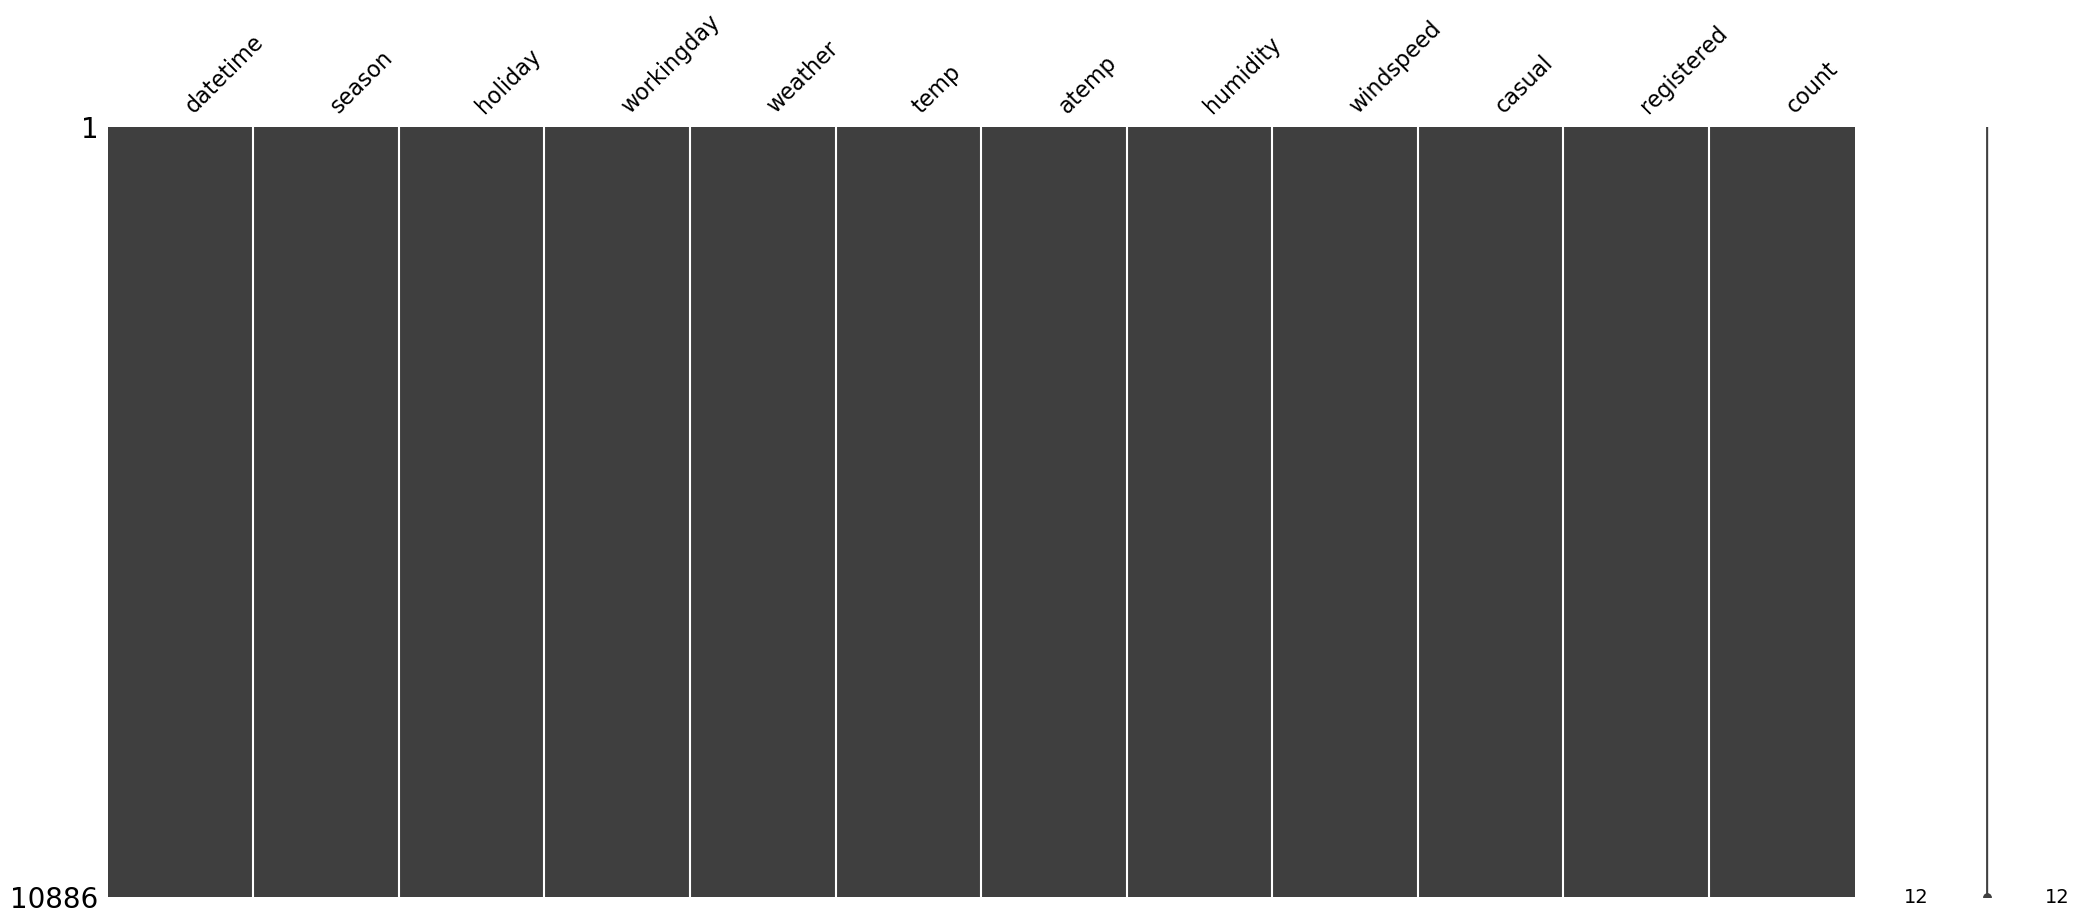

In [161]:
# Missing value detection
msno.matrix(df)

It seems that the dataset has no missing value.

### Initial feature engineering

Some of the features are encoded as numeric values represented by number from 1-4.   
For better understanding the seasons and weather observations, as a first step we replace those number with meaningful words.  

season
<ul>
 <li>1 ==> spring </li>
 <li>2 ==> summer </li>
 <li>3 ==> fall </li>
 <li>4 ==> winter </li>
 </ul>
        
weather
<ul>
 <li>1 Clear, Few clouds, partly cloudy ==> sunny </li>
 <li>2 Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ==> partly_cloudy_mist </li>
 <li>3 Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds ==> rainy </li>
 <li>4 Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog ==> stormy </li>
 </ul>

 holiday
<ul>
 <li>1 ==> yes </li>
 <li>2 ==> no </li>
 </ul>

 workingday
<ul>
 <li>1 ==> weekday </li>
 <li>2 ==> weekend </li>
 </ul>

In [162]:
df['season'] = df['season'].map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})
df['weather'] = df['weather'].map({1:'sunny', 2:'partly_cloudy_mist', 3:'rainy', 4:'storm'})
df['holiday'] = df['holiday'].map({1: 'yes', 0:'no'})
df['workingday'] = df['workingday'].map({1: 'yes', 0: 'no'})

## EDA

Let's have a look the number of observations by plotting the weather and the season to see some insights.

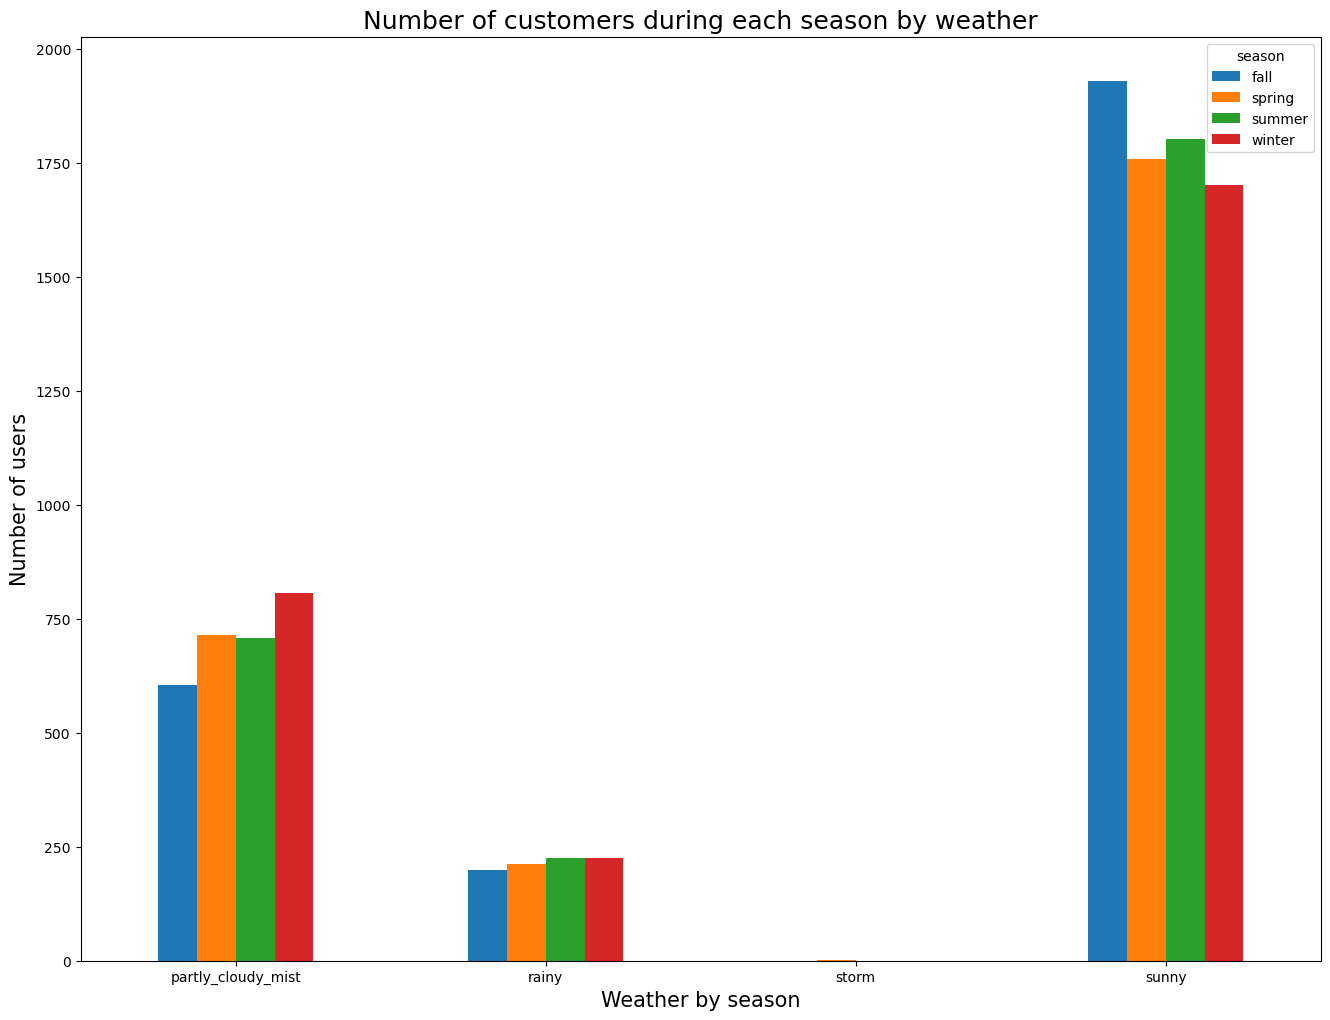

In [163]:
pd.crosstab(df['weather'], df['season']).plot(kind = 'bar')
plt.title('Number of customers during each season by weather', fontsize = 18)
plt.xlabel('Weather by season', fontsize = 15)
plt.ylabel('Number of users', fontsize = 15)
plt.xticks(rotation = 0)
plt.show()

It seems that during the observations most of the time the weather was sunny or partly cloudy.

In [164]:
df.groupby('weather')['season'].count()

weather
partly_cloudy_mist    2834
rainy                  859
storm                    1
sunny                 7192
Name: season, dtype: int64

The weather was during the two year period mostly clear, clear with few clouds and possible mist in the early hours during nights 92% of the time.

In [165]:
# The number of customers by weekday and weekend in the two categories
df.groupby(['workingday'])[['casual', 'registered']].sum()

,casual,registered
workingday,,
no,206037,448835
yes,186098,1244506


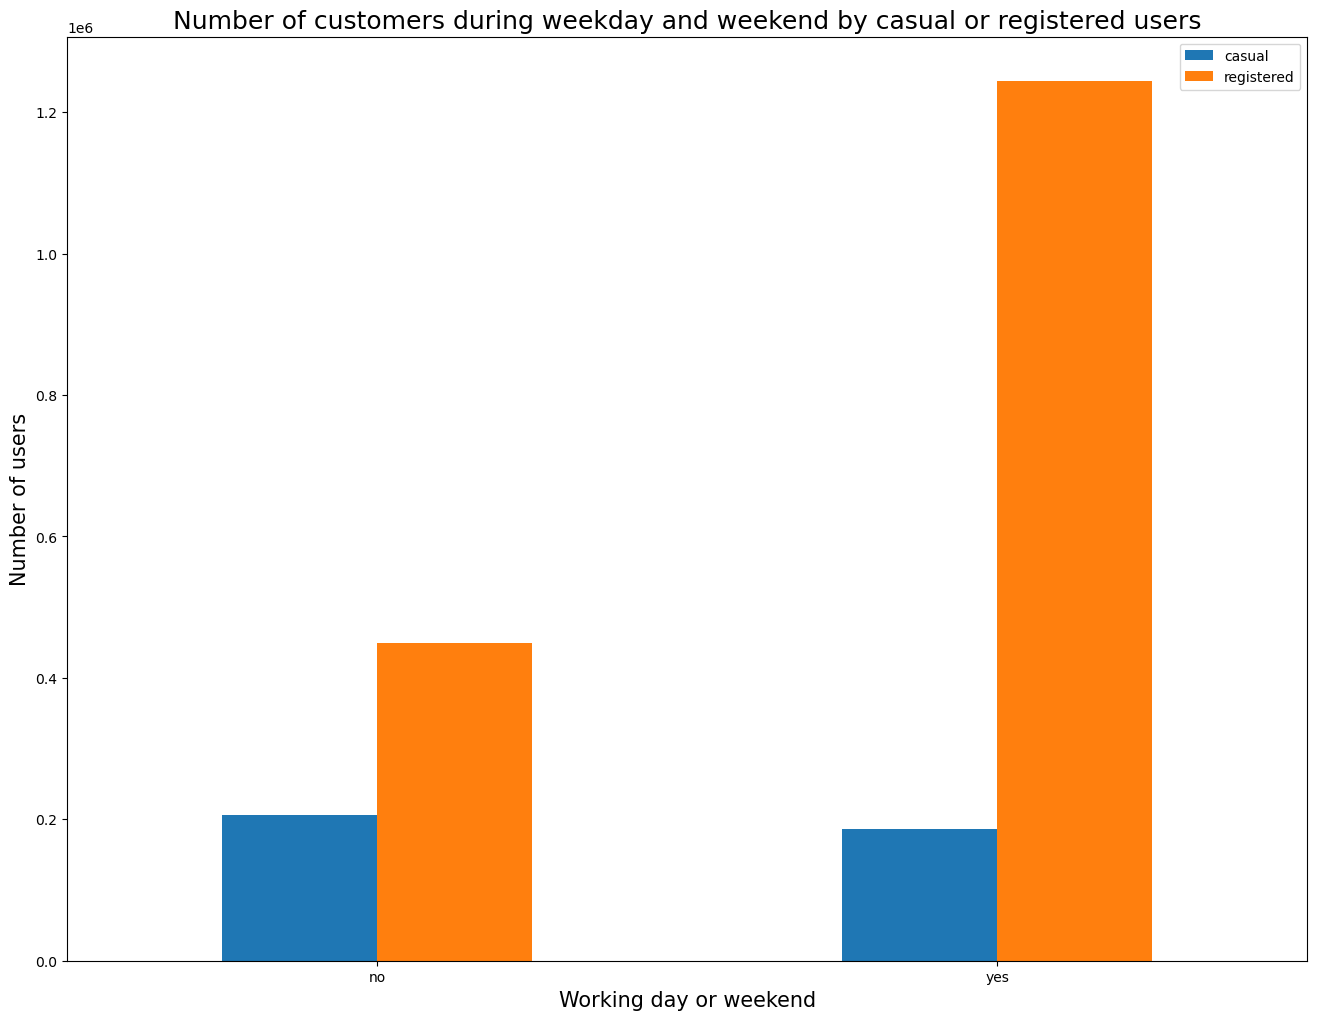

In [166]:
df.groupby(['workingday'])[['casual', 'registered']].sum().plot(kind = 'bar')
plt.title('Number of customers during weekday and weekend by casual or registered users', fontsize = 18)
plt.xlabel('Working day or weekend', fontsize = 15)
plt.ylabel('Number of users', fontsize = 15)
plt.xticks(rotation = 0)
plt.show()

From this crosstable we can see that there are more registered customer used the service during the week, possibly for work.    
The number os casual users is higher during the weekend and nearly half the registered users, meanwhile during the week the number of users    
who used the service in the observation period is much higher.

In [167]:
df.groupby(['holiday'])[['casual', 'registered']].sum()

,casual,registered
holiday,,
no,376964,1650704
yes,15171,42637


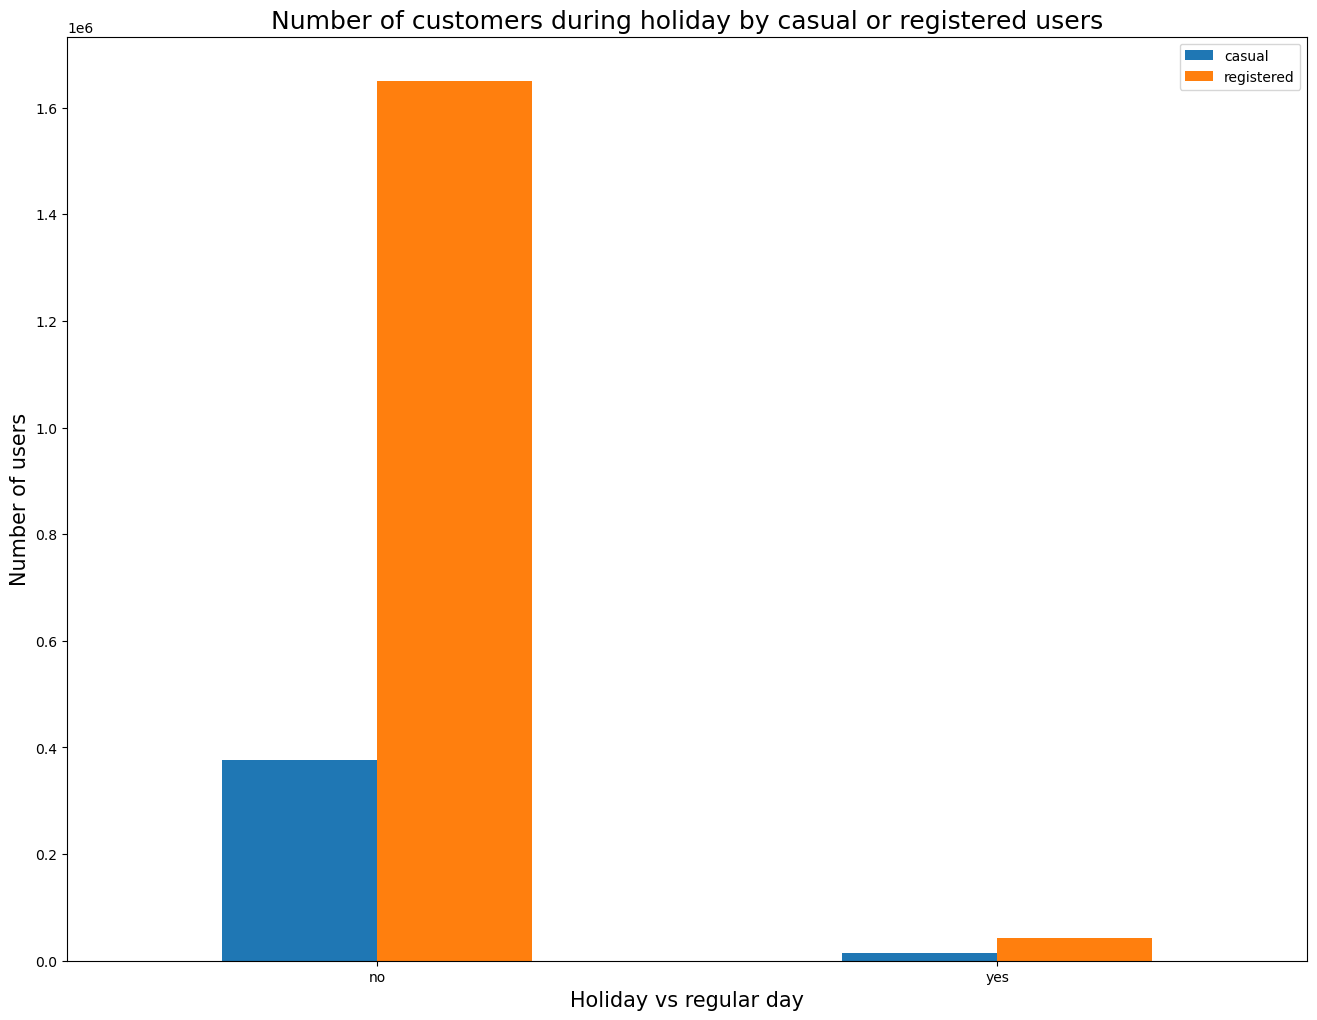

In [168]:
df.groupby(['holiday'])[['casual', 'registered']].sum().plot(kind = 'bar')
plt.title('Number of customers during holiday by casual or registered users', fontsize = 18)
plt.xlabel('Holiday vs regular day', fontsize = 15)
plt.ylabel('Number of users', fontsize = 15)
plt.xticks(rotation = 0)
plt.show()

This groupping shows that the service was used mostly on non holidays but working days.

In [169]:
pd.crosstab(index = df['workingday'], columns = df['weather'])

weather,partly_cloudy_mist,rainy,storm,sunny
workingday,,,,
no,897,224,0,2353
yes,1937,635,1,4839


The weather on holidays versus non holidays.

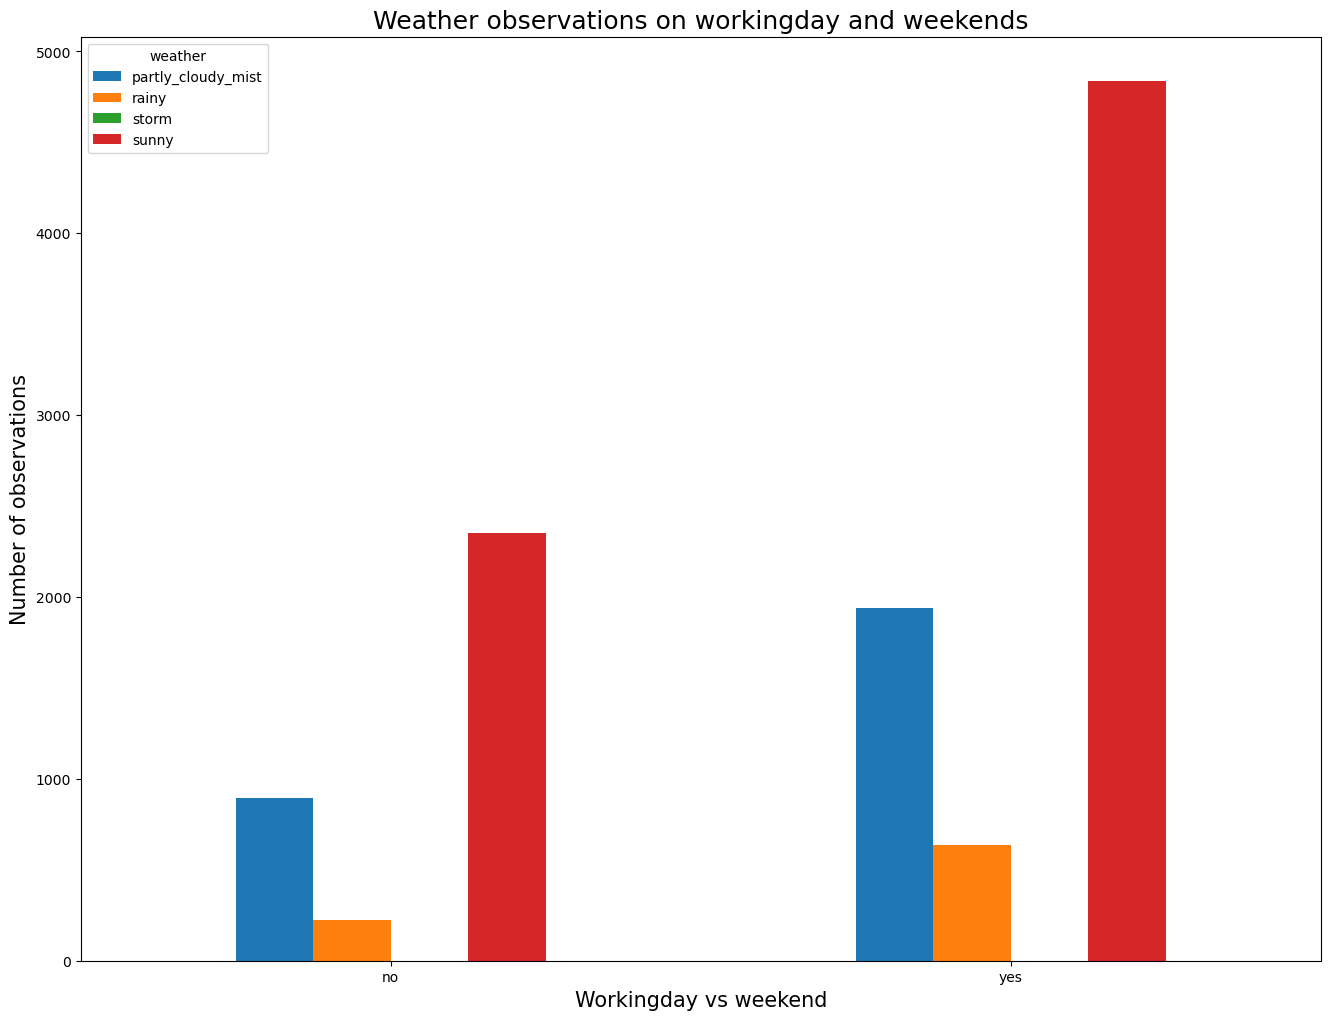

In [170]:
pd.crosstab(index = df['workingday'], columns = df['weather']).plot(kind = 'bar')
plt.title('Weather observations on workingday and weekends', fontsize = 18)
plt.xlabel('Workingday vs weekend', fontsize = 15)
plt.ylabel('Number of observations', fontsize = 15)
plt.xticks(rotation = 0)
plt.show()

In [171]:
pd.crosstab(index = df['holiday'], columns = df['weather'])

weather,partly_cloudy_mist,rainy,storm,sunny
holiday,,,,
no,2742,844,1,6988
yes,92,15,0,204


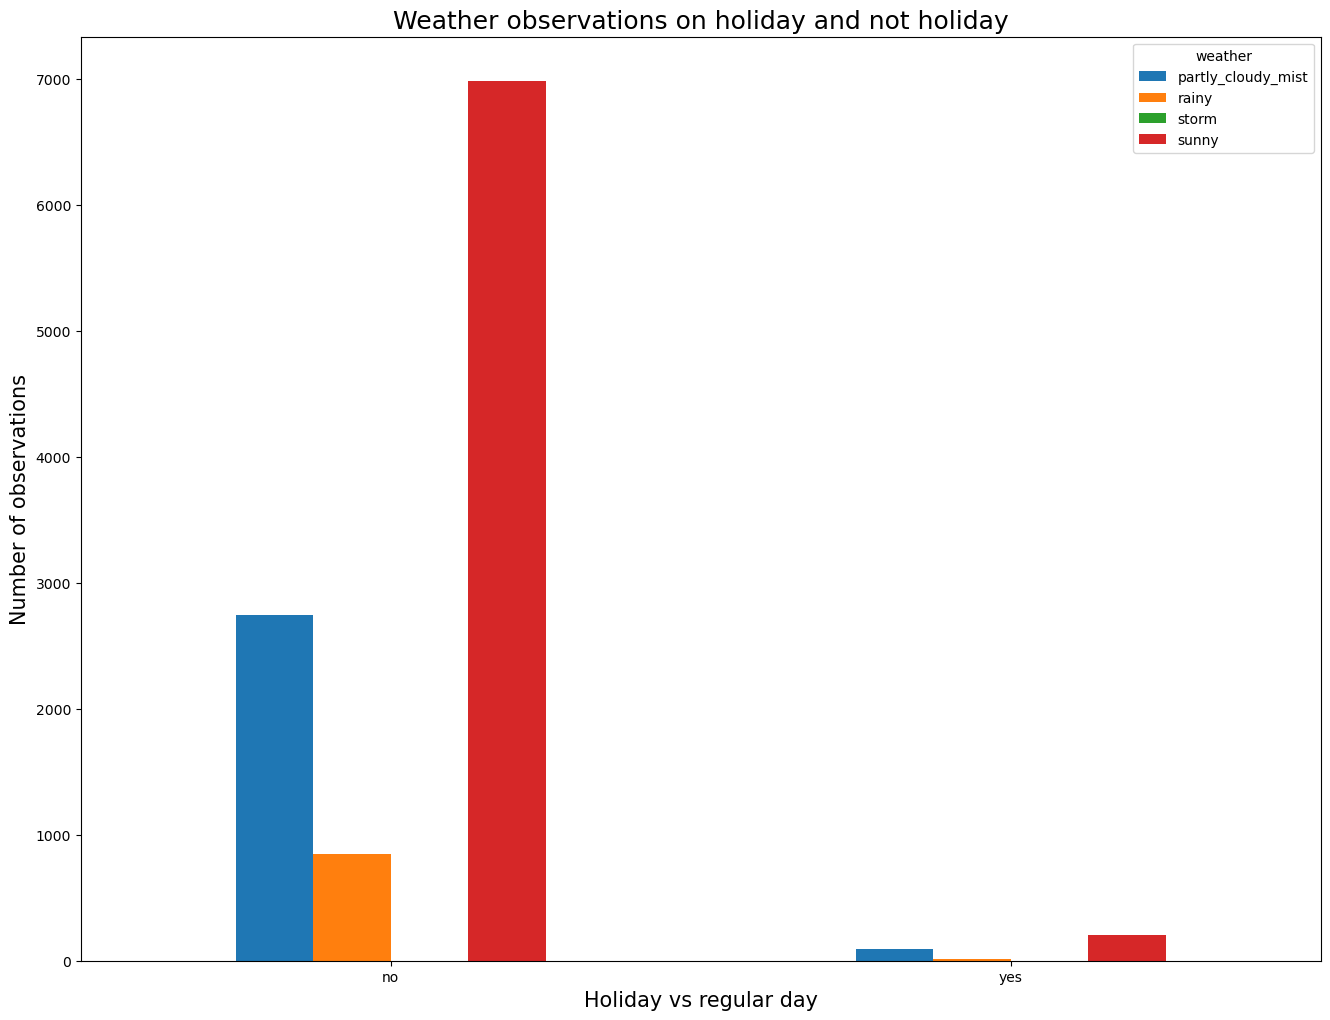

In [172]:
pd.crosstab(index = df['holiday'], columns = df['weather']).plot(kind = 'bar')
plt.title('Weather observations on holiday and not holiday', fontsize = 18)
plt.xlabel('Holiday vs regular day', fontsize = 15)
plt.ylabel('Number of observations', fontsize = 15)
plt.xticks(rotation = 0)
plt.show()

In [173]:
season_temp_humidity = df[['temp', 'season', 'humidity', 'windspeed']]
avg_values = season_temp_humidity.groupby(['season'])[['temp', 'humidity', 'windspeed']].mean()
avg_values

,temp,humidity,windspeed
season,,,
fall,28.789111,64.123674,11.508862
spring,12.530491,56.297841,14.636978
summer,22.823483,60.852909,13.405607
winter,16.649239,66.173738,11.678147


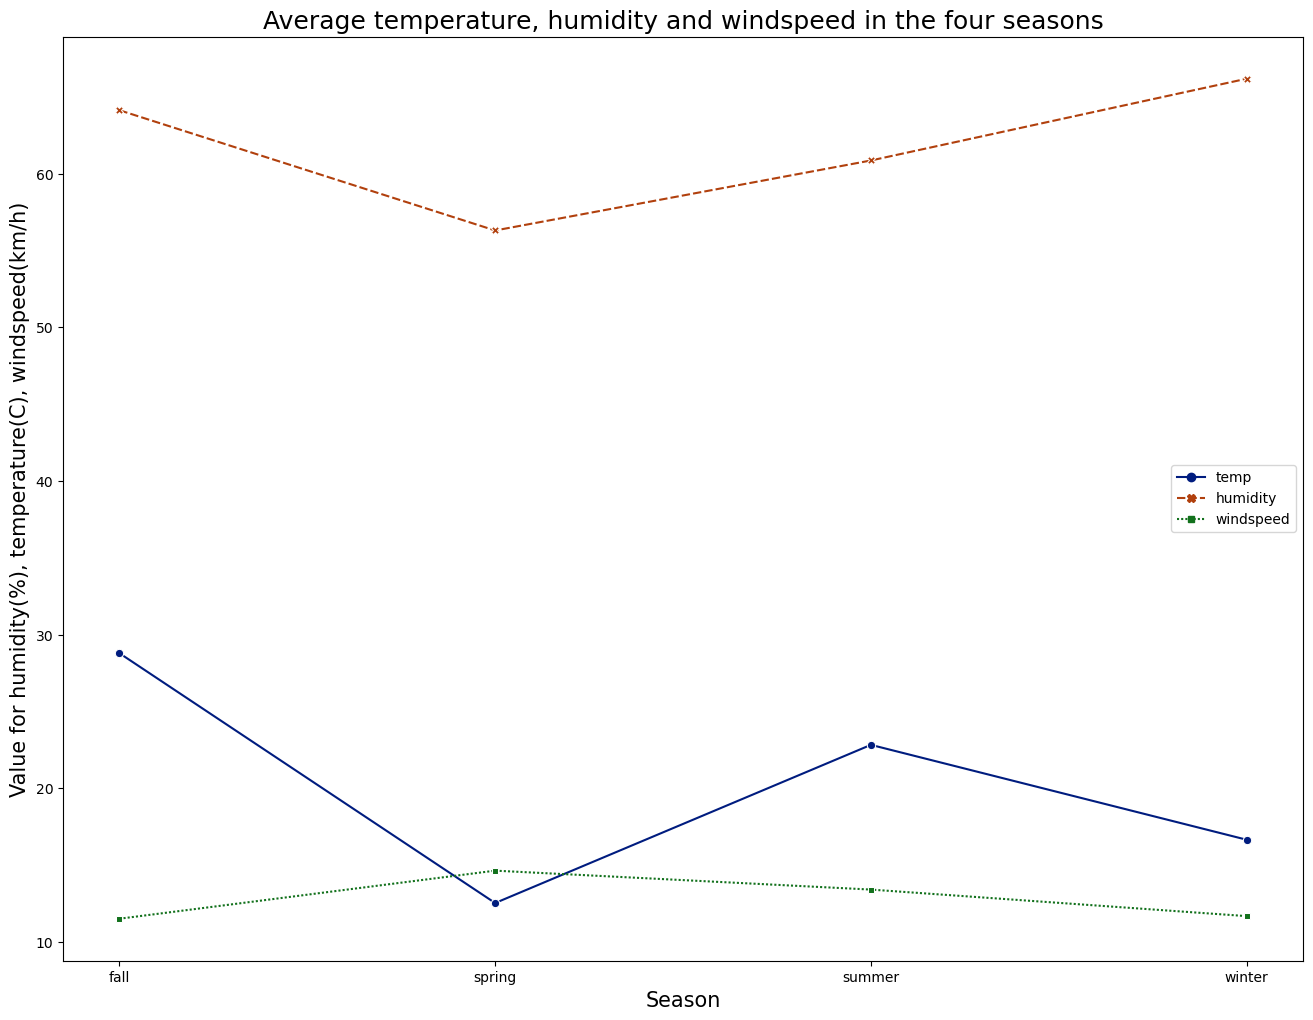

In [174]:
sns.lineplot(data = avg_values, markers = True, palette = 'dark')
plt.title('Average temperature, humidity and windspeed in the four seasons', fontsize = 18)
plt.xlabel('Season', fontsize = 15)
plt.ylabel('Value for humidity(%), temperature(C), windspeed(km/h)', fontsize = 15)
plt.show()

The graph shows that during the average observations of temperature, humidity and windspeed, the humidity remained high but with a slight upward trend.   
The temperature rose and fall from spring to fall and droped back during the winter.   
The windspeed remained low all year around with almost no trend at all.

## Feature engineering

The data has hourly observations that can be collased into daily entries. By doing that we use the mean temperature, humidity and windspeed for that day and summing up all the users daily.

In [175]:
df['datetime'] = pd.to_datetime(df['datetime'])
df_daily = df.resample('24h', on = 'datetime').agg(dict(season = 'last',
                                                                  holiday = 'last',
                                                                  workingday = 'last',
                                                                  weather = 'last',
                                                                  temp = 'mean',
                                                                  atemp = 'mean',
                                                                  humidity = 'mean',
                                                                  windspeed = 'mean',
                                                                  casual = 'sum',
                                                                  registered = 'sum',
                                                                  count = 'sum'))
df_daily.index = df_daily.index.to_period('D').to_timestamp()

The new dataset now contains daily observations only.

In [176]:
df_daily.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01,spring,no,no,partly_cloudy_mist,14.110833,18.181250,80.583333,10.749871,331,654,985
2011-01-02,spring,no,no,sunny,14.902609,17.686957,69.608696,16.652122,131,670,801
2011-01-03,spring,no,yes,sunny,8.050909,9.470227,43.727273,16.636709,120,1229,1349
2011-01-04,spring,no,yes,sunny,8.200000,10.606087,59.043478,10.739809,108,1454,1562
2011-01-05,spring,no,yes,sunny,9.305217,11.463478,43.695652,12.522300,82,1518,1600


The data has been collapsed into daily observations and entries have been created for dates where there are no information available.   
There is a week of missing data for each month hence we simply remove those rows from the downsized time series.

<Axes: >

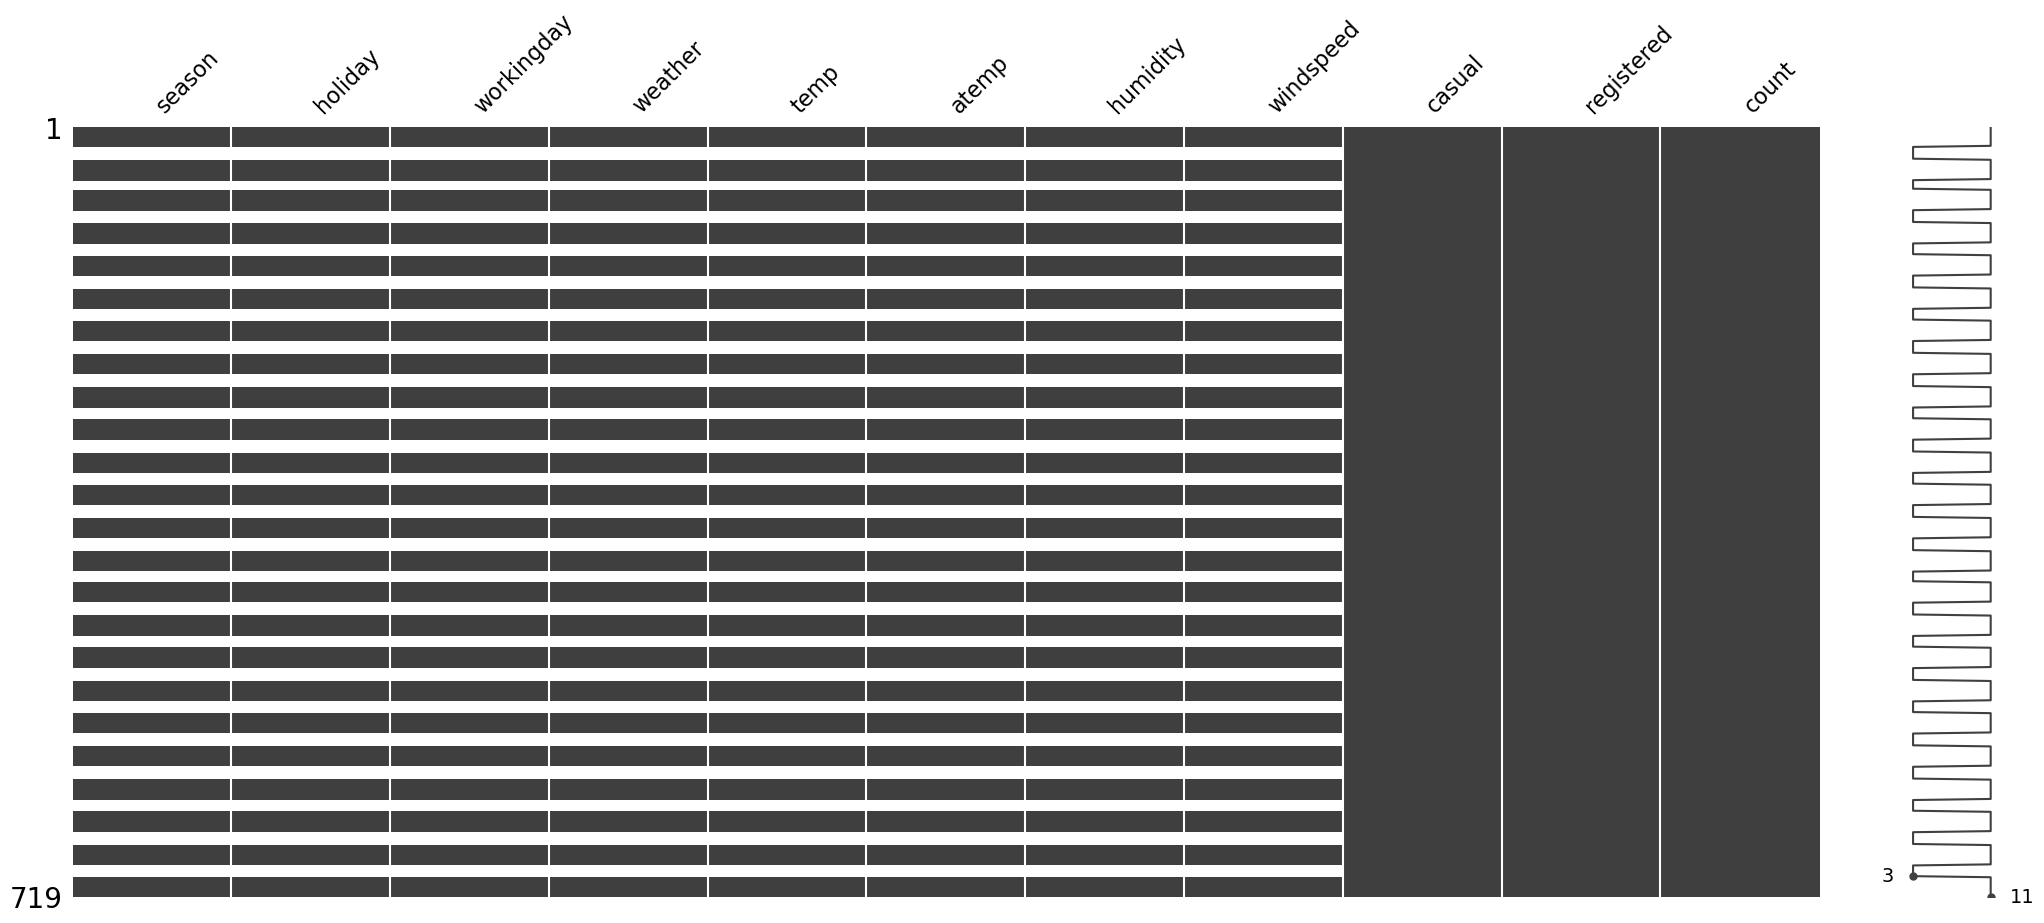

In [177]:
df_daily.isna().sum()
msno.matrix(df_daily)

In [178]:
df_daily = df_daily.replace('NaN', np.NaN)
df_daily.dropna(axis=0, how='any', inplace = True)
df_daily.isna().sum()


season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

What is the change in number between registered and casual users from one year to the next one. 
- Has the difference been increased or the it is roughly the same?    
- How does it change with season?   

It is logical to assume that the number of casual users decreases during colder months or in bad weather conditions. However, the registered users,  
who primarily use it for transportation to work rather than occasional use, experience a slight decrease but not a significant one.  
Let's create a new column with the difference between the two for every observation.

In [179]:
df_daily['user_diff'] = df_daily['registered'] - df_daily['casual']
df_daily['year'] = pd.DatetimeIndex(df_daily.index).year
df_daily.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,user_diff,year
datetime,,,,,,,,,,,,,
2011-01-01,spring,no,no,partly_cloudy_mist,14.110833,18.181250,80.583333,10.749871,331,654,985,323,2011
2011-01-02,spring,no,no,sunny,14.902609,17.686957,69.608696,16.652122,131,670,801,539,2011
2011-01-03,spring,no,yes,sunny,8.050909,9.470227,43.727273,16.636709,120,1229,1349,1109,2011
2011-01-04,spring,no,yes,sunny,8.200000,10.606087,59.043478,10.739809,108,1454,1562,1346,2011
2011-01-05,spring,no,yes,sunny,9.305217,11.463478,43.695652,12.522300,82,1518,1600,1436,2011


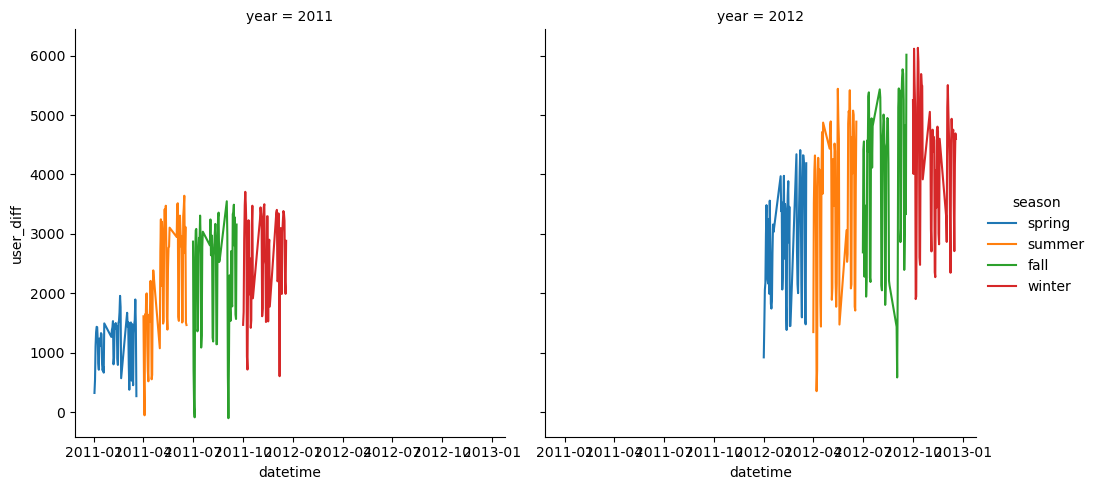

In [180]:
sns.relplot(data = df_daily,
            x = 'datetime',
            y = 'user_diff',
            col = 'year',
            hue = 'season',
            kind = 'line')

In [181]:
df_daily[['season', 'holiday', 'workingday','weather']] = df_daily[['season', 'holiday', 'workingday','weather']].apply(lambda x: x.astype('category'), axis = 0)
df_daily.info()
type(df_daily.index)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 456 entries, 2011-01-01 to 2012-12-19
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      456 non-null    category
 1   holiday     456 non-null    category
 2   workingday  456 non-null    category
 3   weather     456 non-null    category
 4   temp        456 non-null    float64 
 5   atemp       456 non-null    float64 
 6   humidity    456 non-null    float64 
 7   windspeed   456 non-null    float64 
 8   casual      456 non-null    int64   
 9   registered  456 non-null    int64   
 10  count       456 non-null    int64   
 11  user_diff   456 non-null    int64   
 12  year        456 non-null    int32   
dtypes: category(4), float64(4), int32(1), int64(4)
memory usage: 52.4 KB


pandas.core.indexes.datetimes.DatetimeIndex

## Data Visualization

### Registered and casual user visualization

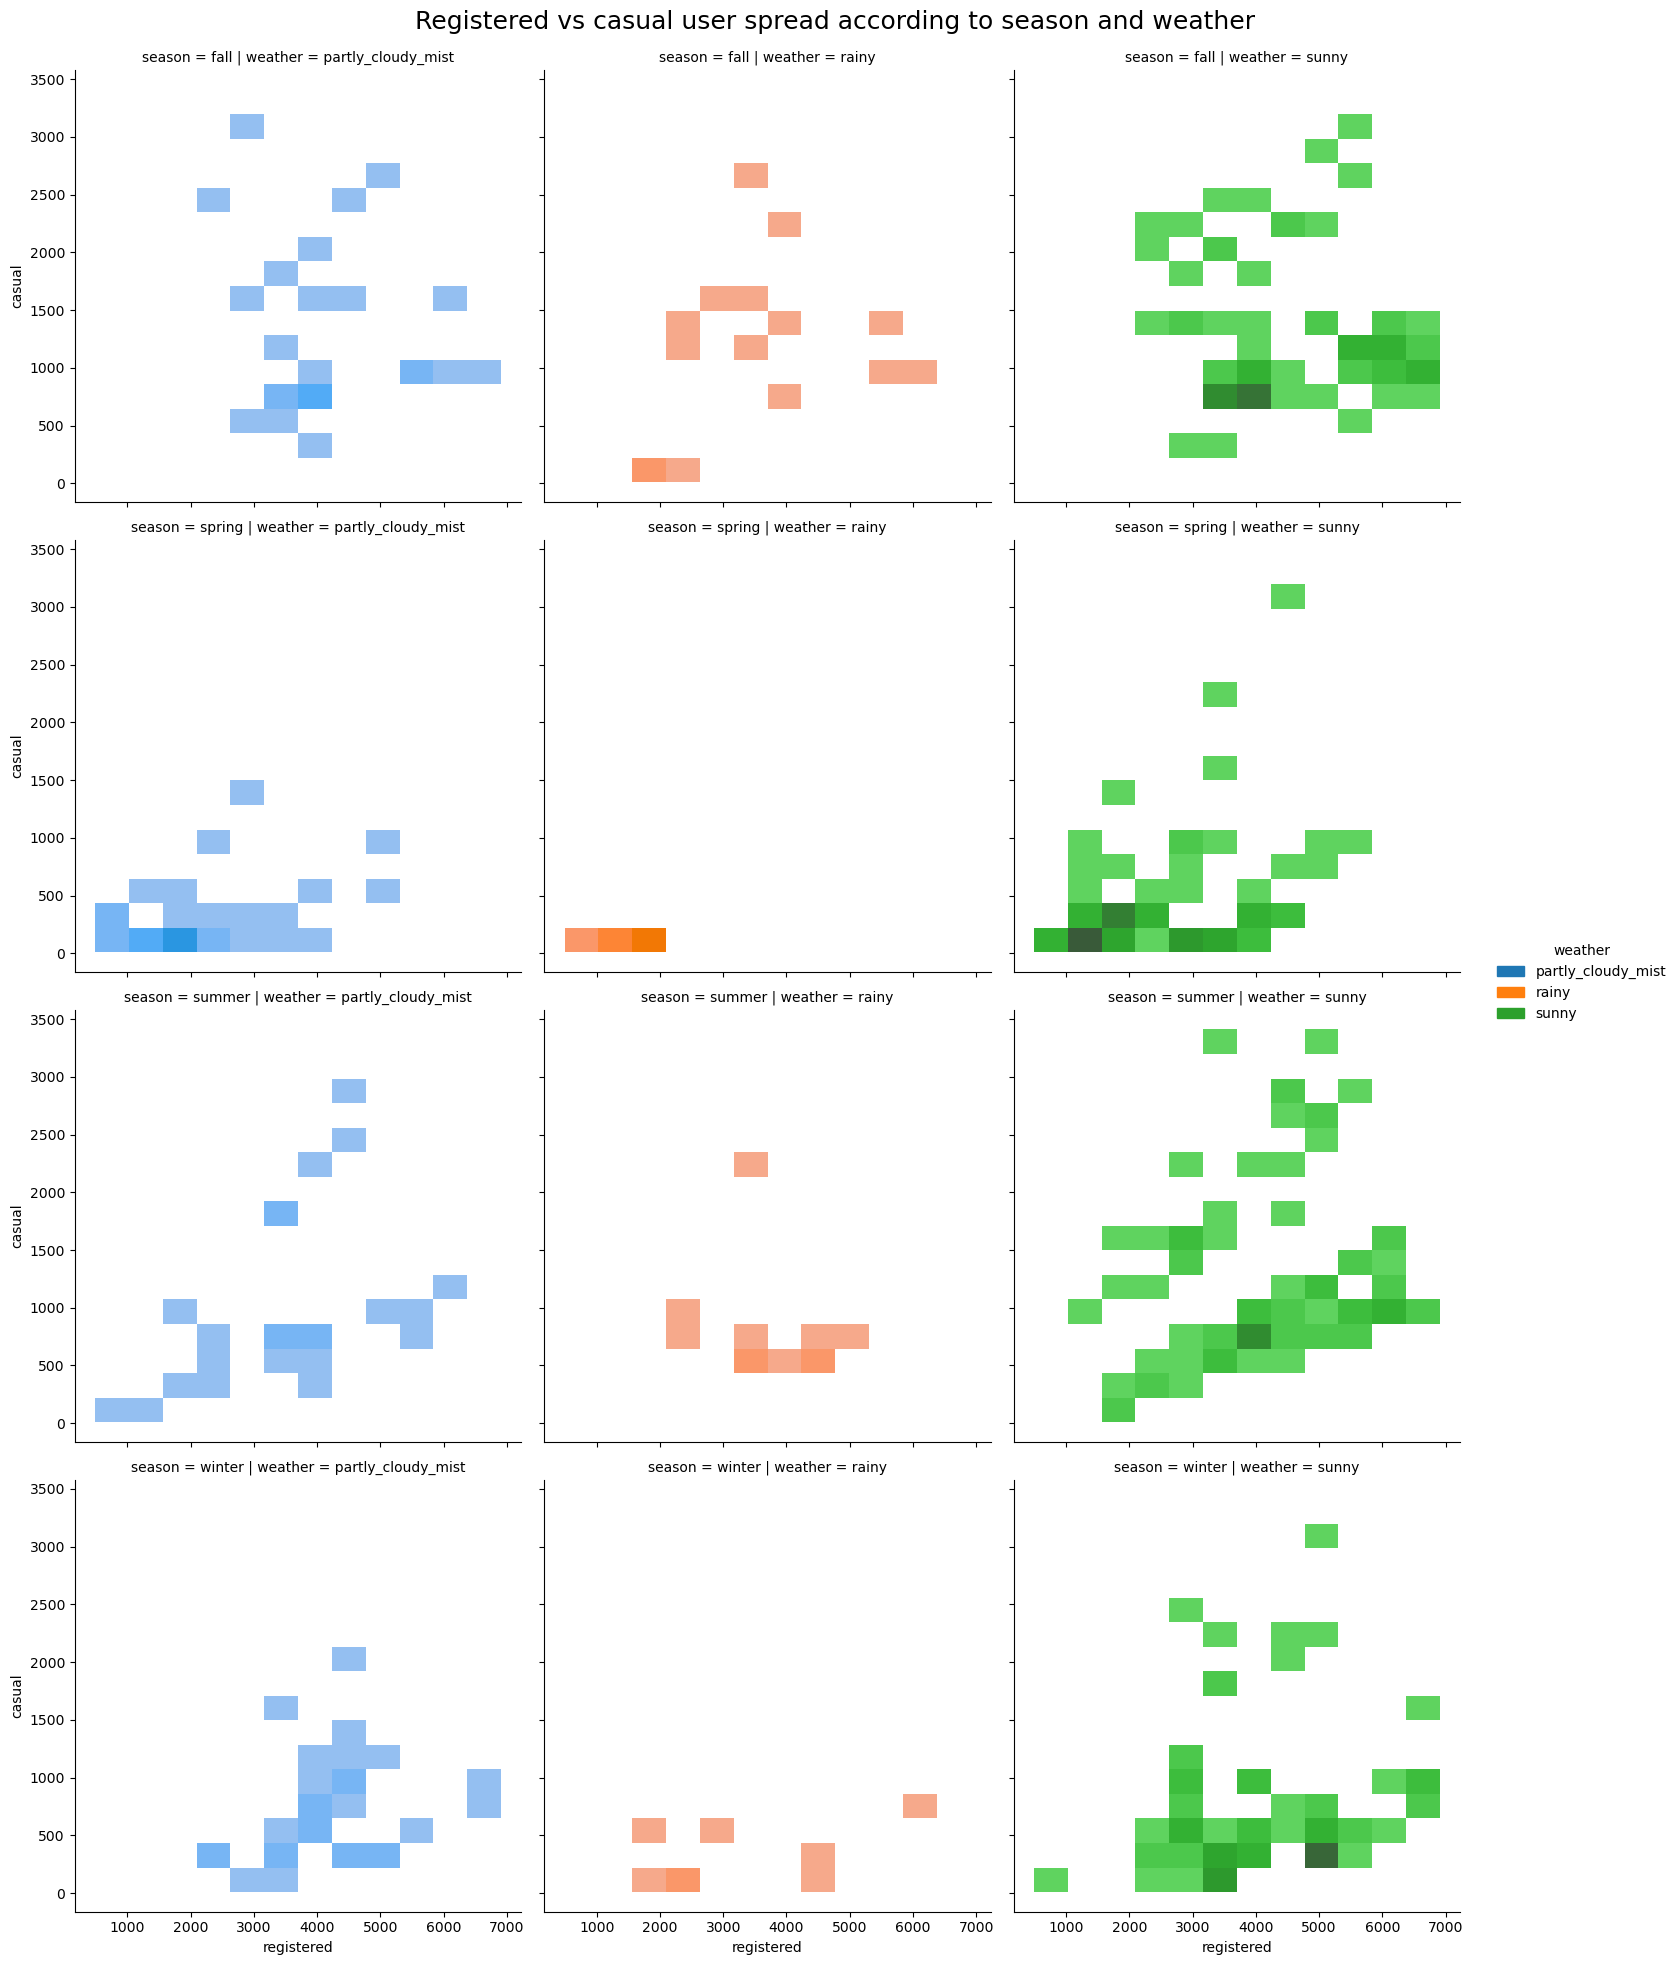

In [182]:
g = sns.displot(data = df_daily, x = 'registered', y = 'casual', col = 'weather', row = 'season', hue = 'weather')
g.fig.subplots_adjust(top = 0.95)
g.fig.suptitle('Registered vs casual user spread according to season and weather', fontsize = 18)
plt.show()

The plot shows the relationship between users and how the service was used according to the weather condition in different seasons.    
The number of registered users is much higher than casual users, and it seems that the number of casual users drop in the    
colder month and also if the weather was bad. This suggests that casual users more likely used the service for pleasure purposes    
rather than possibly work commuting.

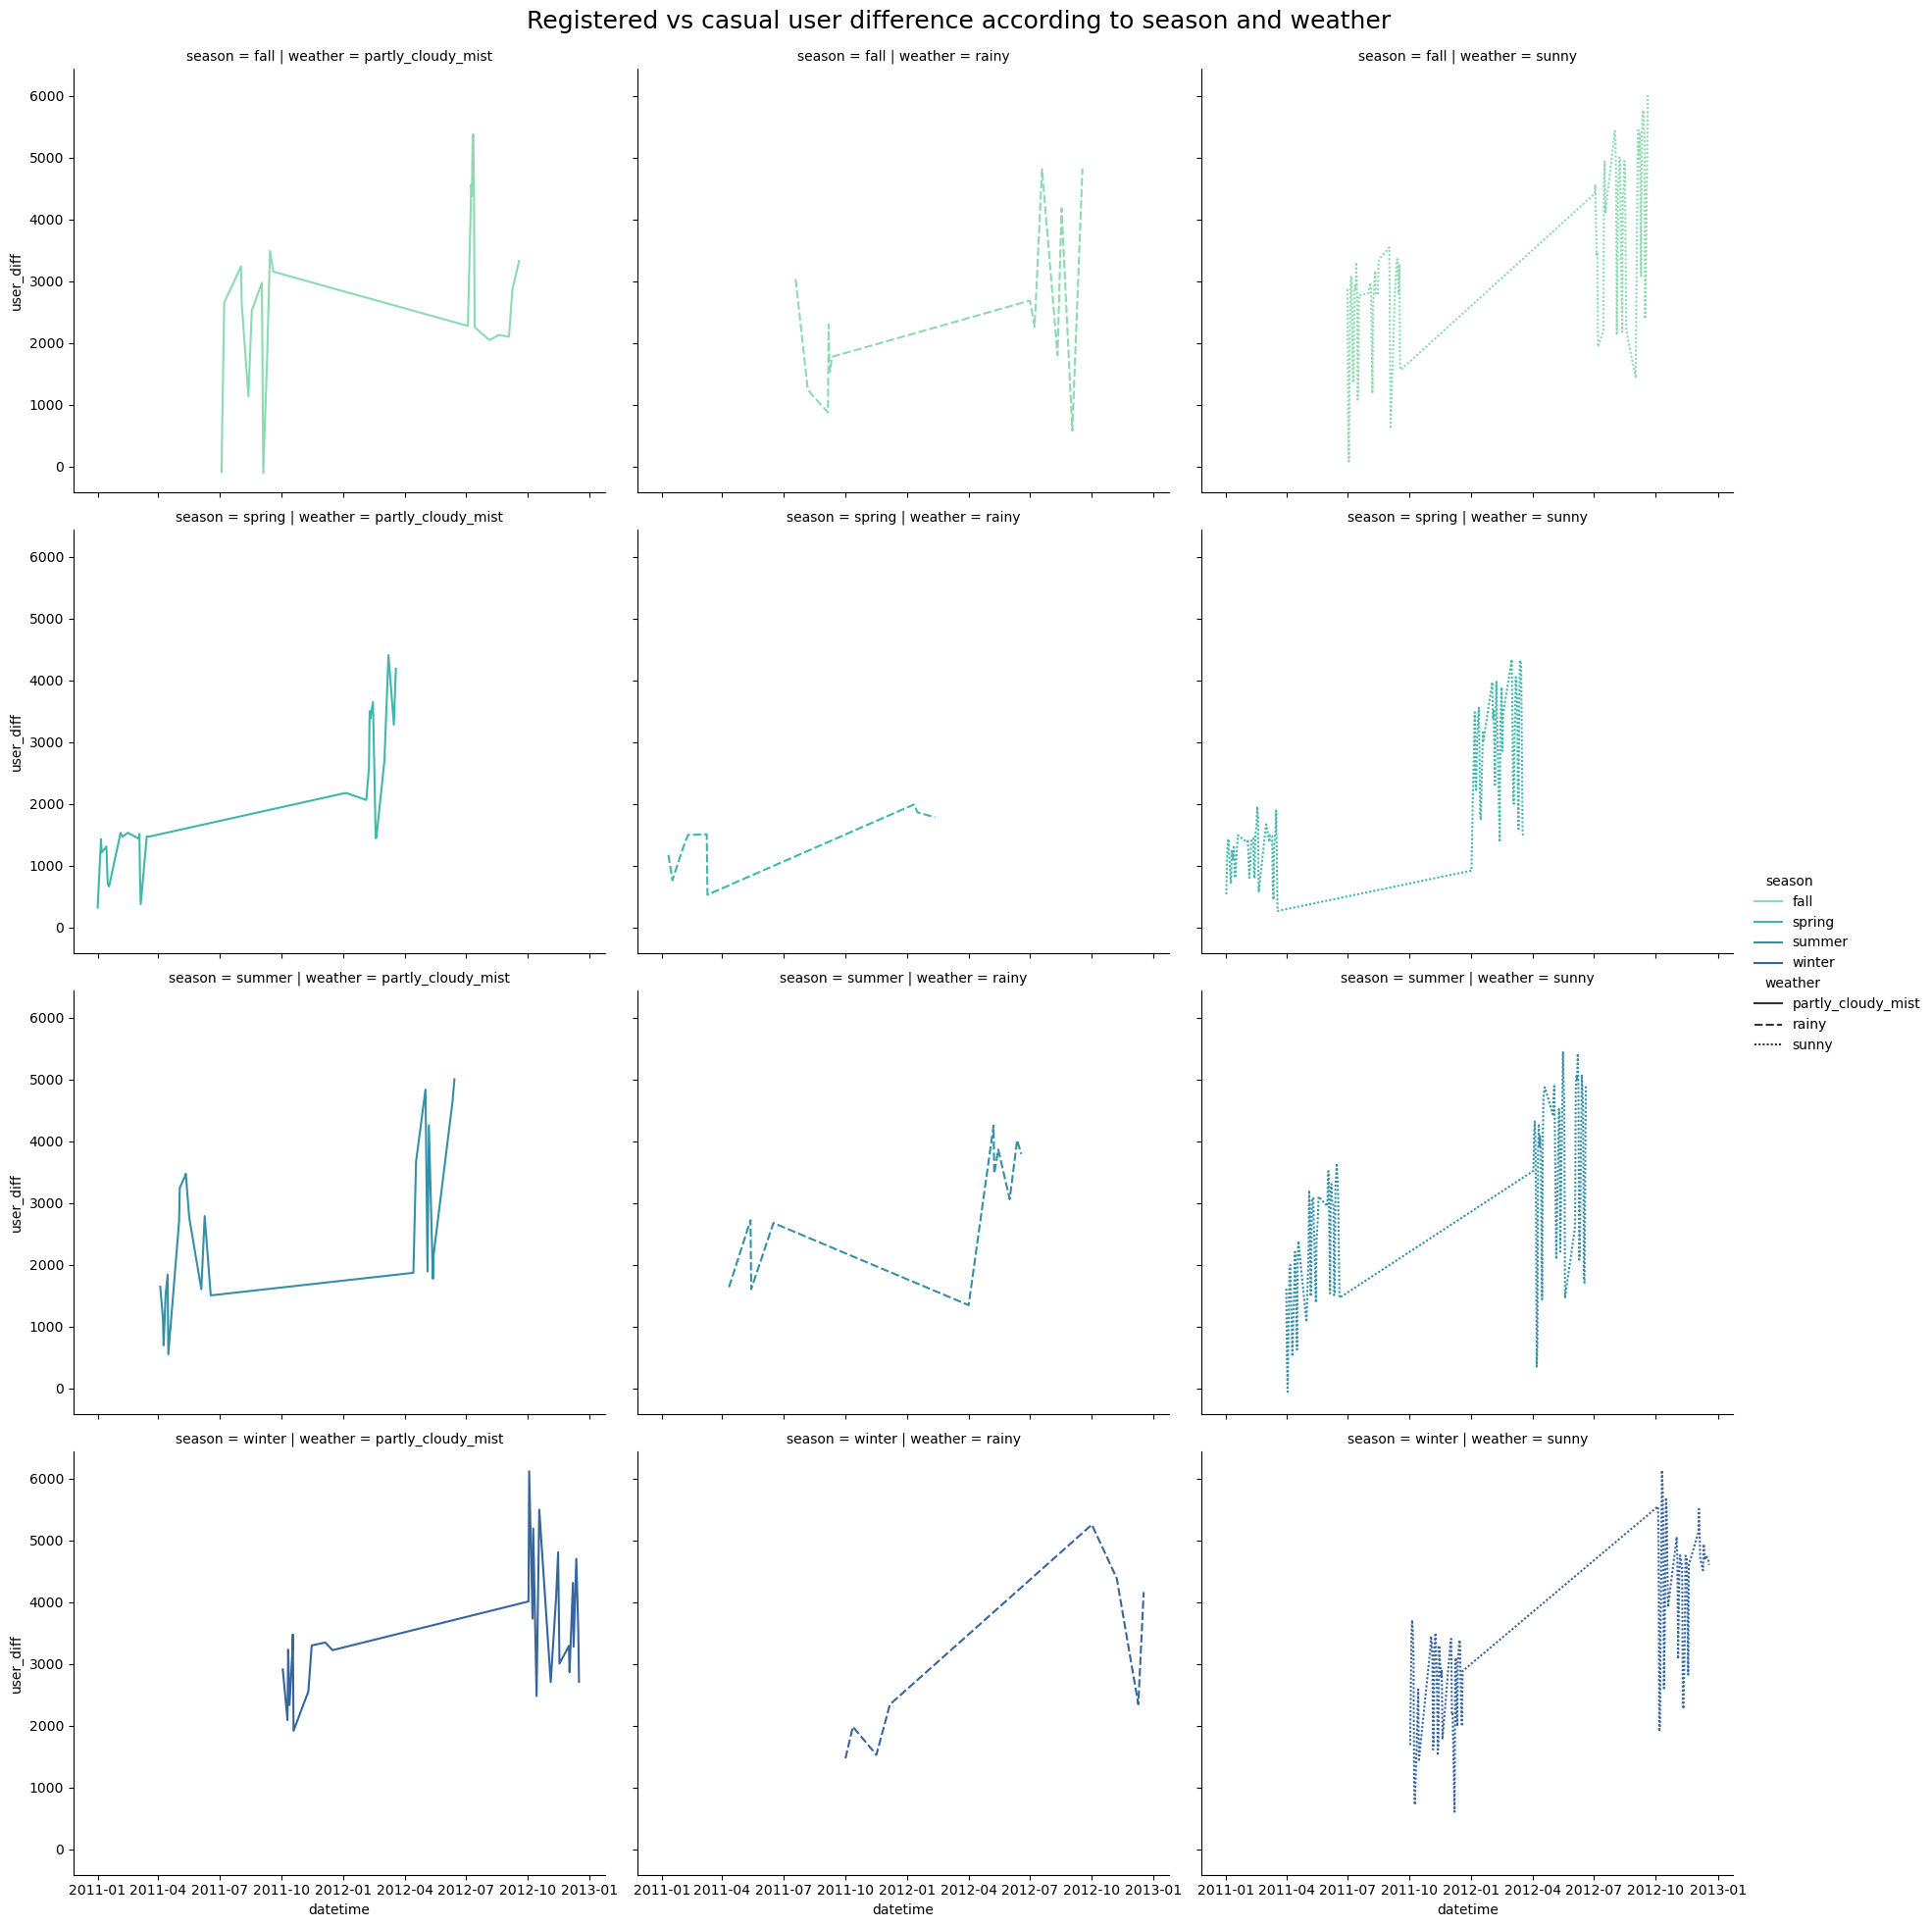

In [183]:
palette = sns.color_palette("mako_r", 6)
g = sns.relplot(data = df_daily,
                x = df_daily.index,
                y = 'user_diff', 
                kind = 'line', 
                hue = 'season', 
                style = 'weather', 
                palette = palette,
                col = 'weather',
                row = 'season',
                height=5,
                aspect=1.2)
g.fig.subplots_adjust(top = 0.95)
g.fig.suptitle('Registered vs casual user difference according to season and weather', fontsize = 18)
plt.show()

The plot shows the difference between the registered and casual users. In all seasons when the weather was good (sunny and cloudless) the difference between the two groups remained large,    
meaning that more registered users utilized the service. When the weather was colder and rainy this difference seems to be smaller and less erratic.

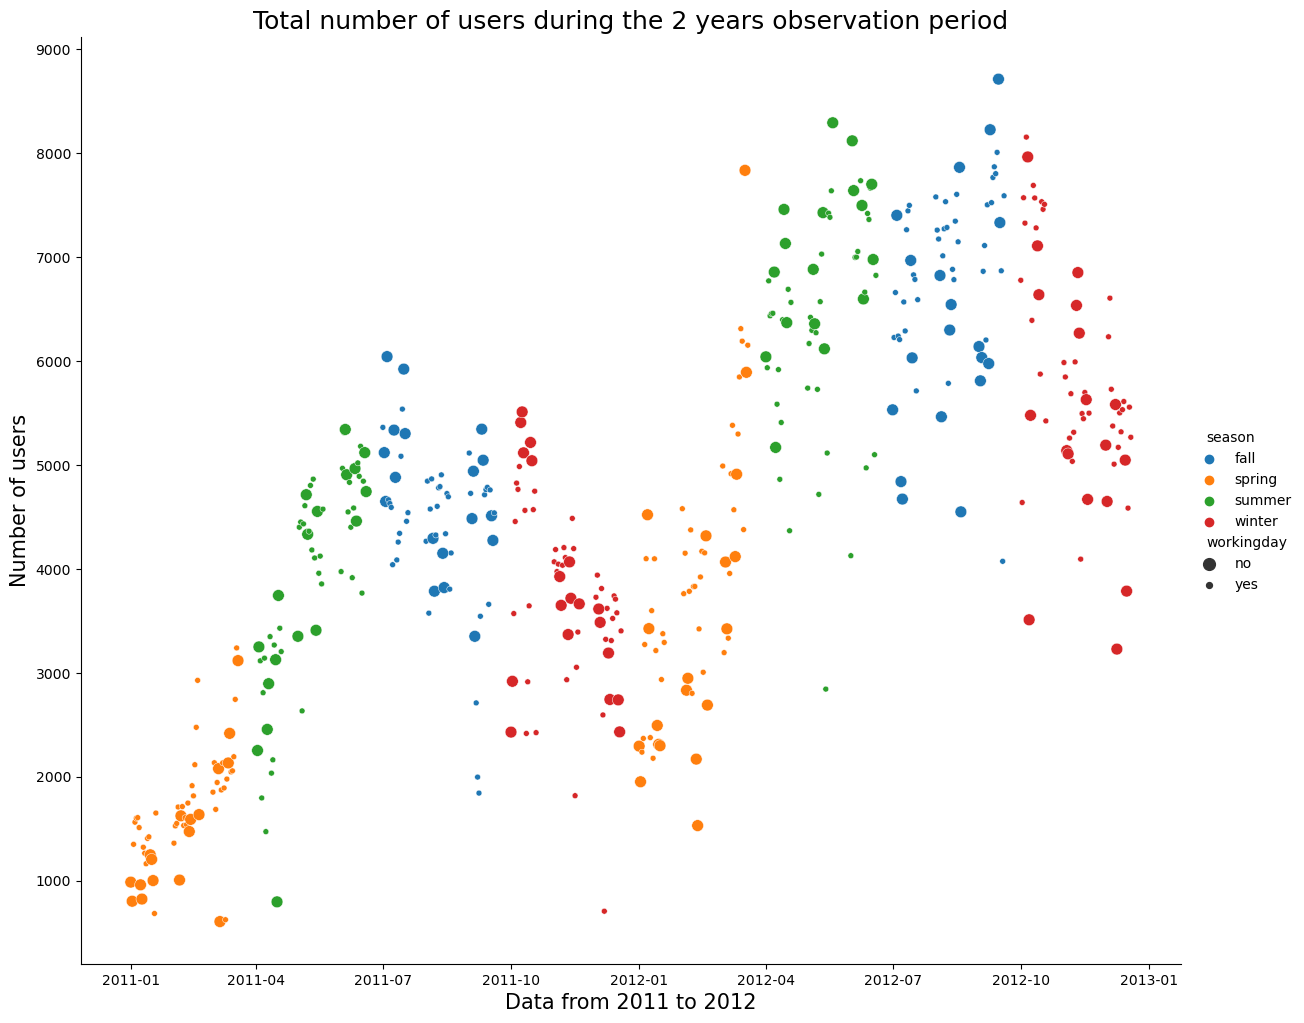

In [184]:
sns.relplot(data = df_daily, 
            x = df_daily.index, 
            y = 'count', 
            hue = 'season',
            size = 'workingday',
            height = 10,
            aspect = 1.2)
plt.title('Total number of users during the 2 years observation period', fontsize = 18)
plt.xlabel('Data from 2011 to 2012', fontsize = 15)
plt.ylabel('Number of users', fontsize = 15)
plt.show()

The plot above shows a clear seasonality in the number of users. From 2011 the total numbers were increased, it droped back in the colder months (4)    
and early spring when the temperature was still low and started to rise again from mid spring. At the end of the year 2012 the numbers plummeted again    
slightly, possibly due to the weather conditions as previous year. Wheather it was a workingday or not seems not significant, seen as the size distribution   
looks random in each season.

<function matplotlib.pyplot.show(close=None, block=None)>

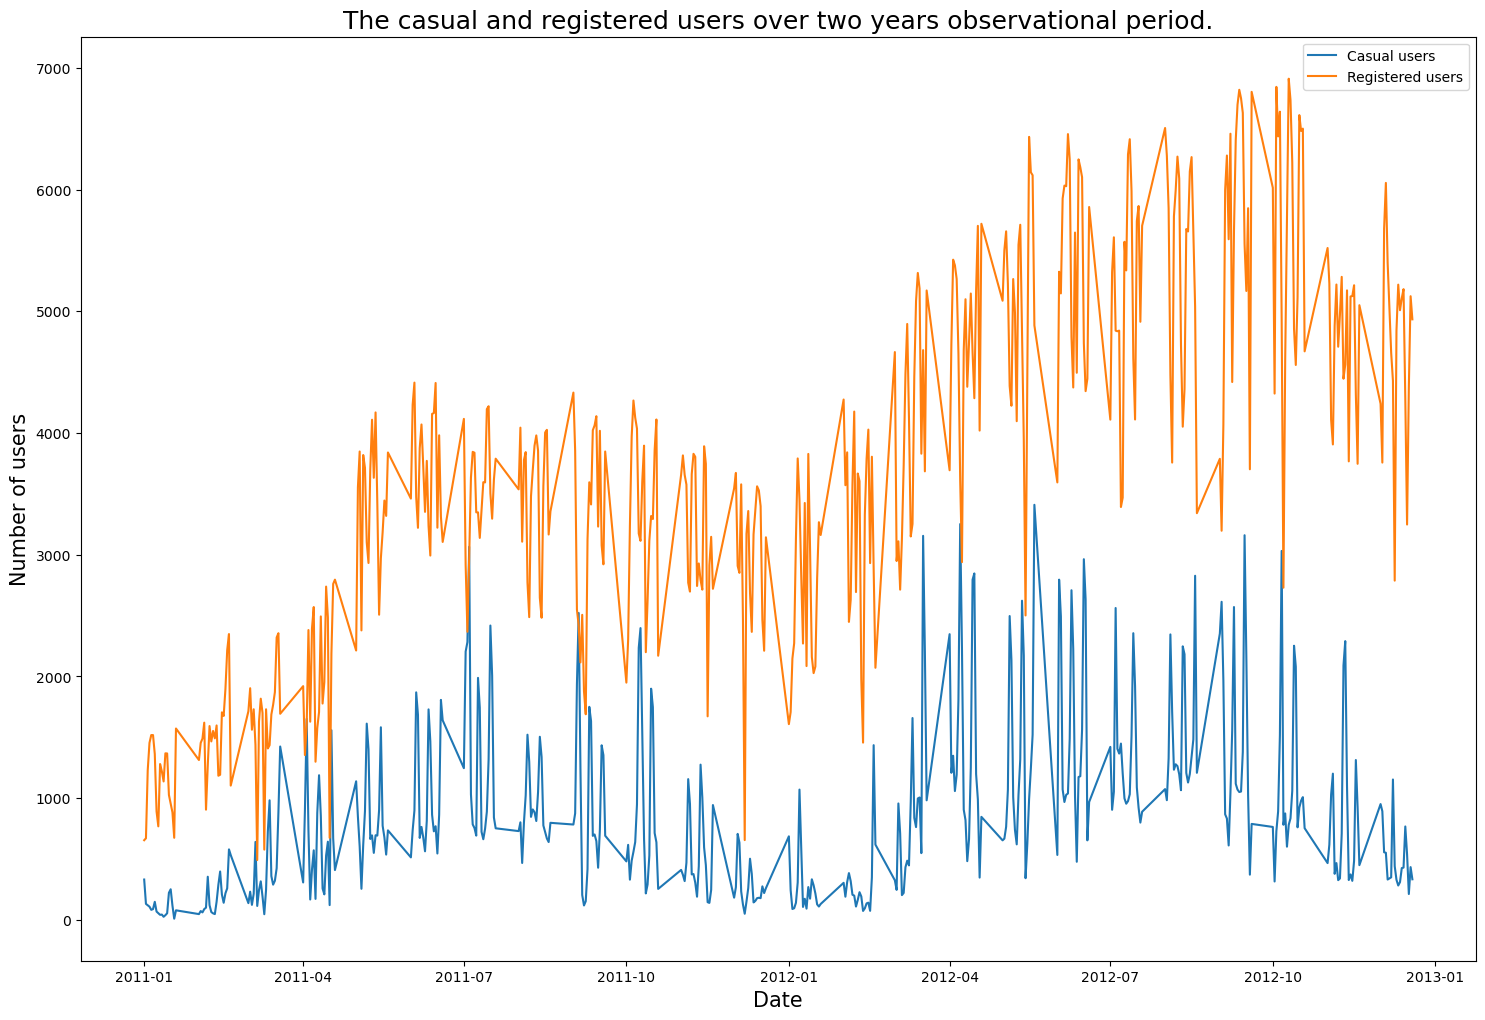

In [185]:
plt.figure(figsize=(18,12))
plt.plot(df_daily.index, df_daily['casual'], label = 'Casual users')
plt.plot(df_daily.index, df_daily['registered'], label = 'Registered users')
plt.title('The casual and registered users over two years observational period.', fontsize = 18)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Number of users', fontsize = 15)
plt.legend()
plt.show

Time series plot of the two groups shows upward trend, increase in the number of both users and some seasonality.   
The number of users dropped at the end and beginning of the year that we can assume is due to the poorer weather conditions.

### Weather related visualization

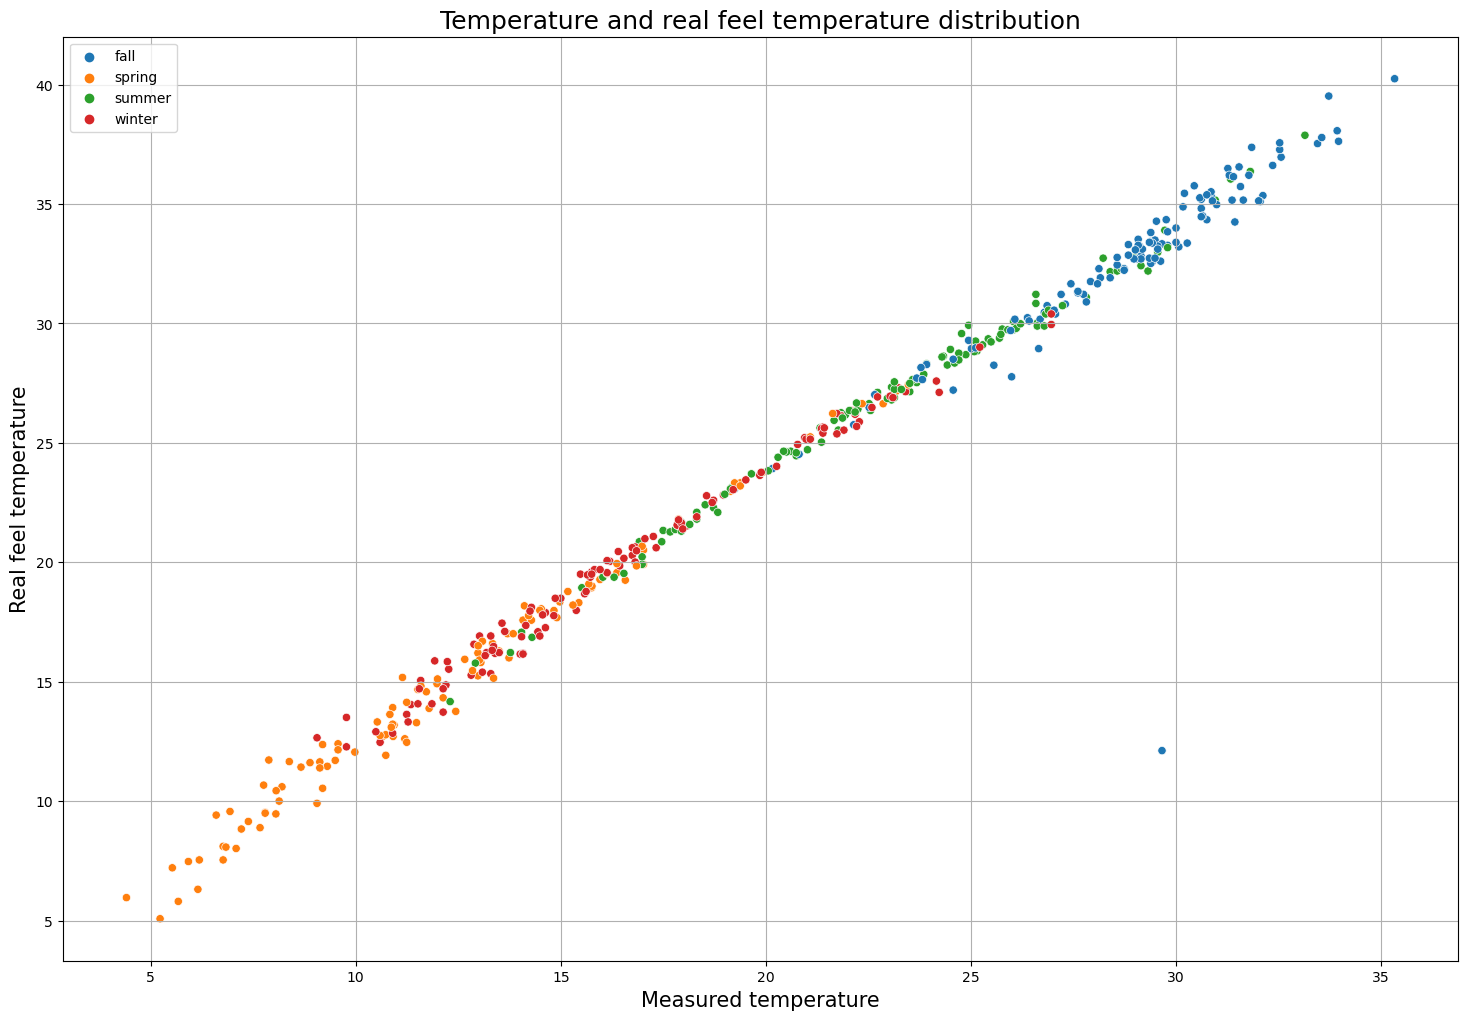

In [186]:
fig = plt.figure(figsize=(18, 12))
text_labels = ['winter', 'spring', 'summer', 'autumn']
sns.scatterplot(data = df_daily,
                x = 'temp',
                y = 'atemp',
                hue = 'season')

plt.title('Temperature and real feel temperature distribution', fontsize = 18)
plt.xlabel('Measured temperature', fontsize = 15)
plt.ylabel('Real feel temperature', fontsize = 15)
plt.legend()
plt.grid()

The temperature and real feel temperature breakdown by seasons, shows an almost perfect correlation, just what we would expect.    
The seasonal changes shown in colors that is also seems right according to the seasonal changes.

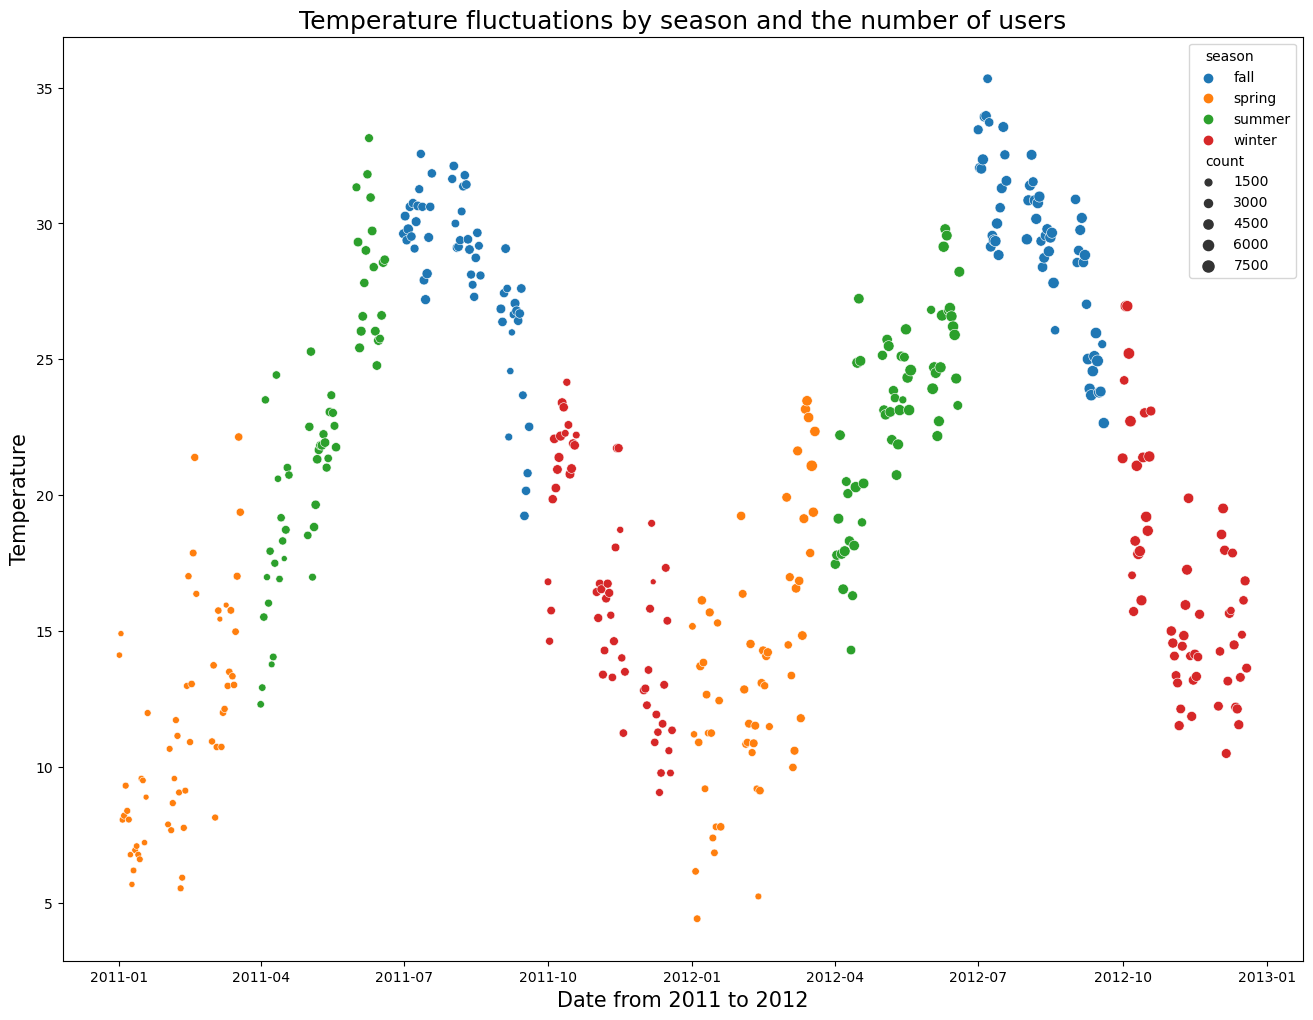

In [187]:
sns.scatterplot(data = df_daily,
                x = df_daily.index,
                y = 'temp',
                hue = 'season',
                size = 'count')
plt.title('Temperature fluctuations by season and the number of users', fontsize = 18)
plt.xlabel('Date from 2011 to 2012', fontsize = 15)
plt.ylabel('Temperature', fontsize = 15)
plt.show()

Text(0.5, 1.0, 'Humidity distribution')

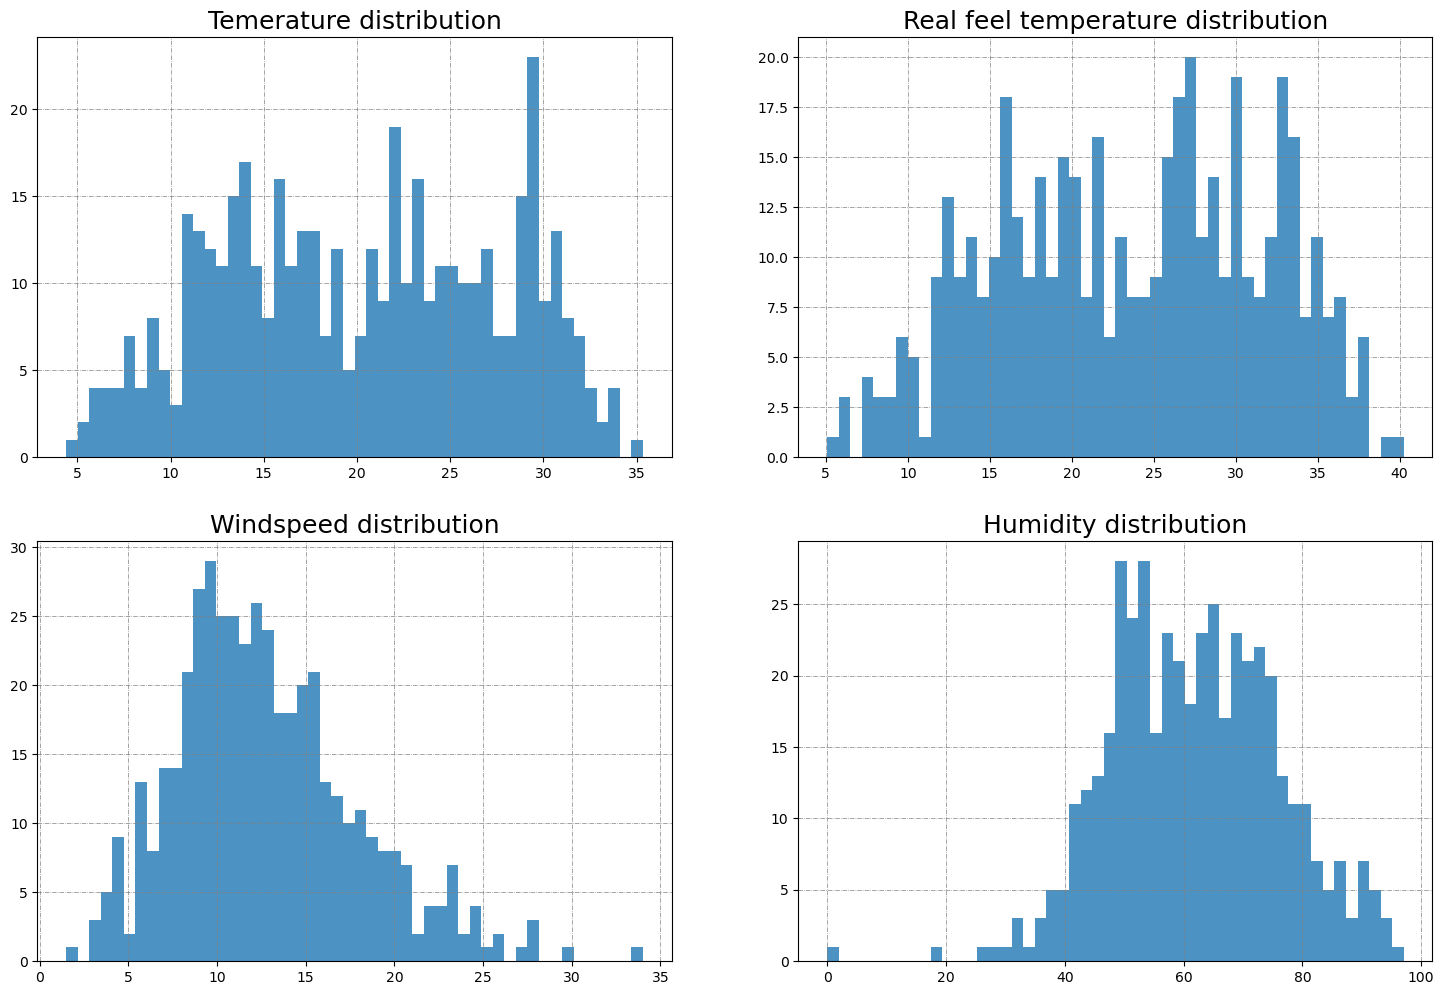

In [188]:
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize=(18, 12))

ax1.grid(color ='grey', linestyle ='-.', linewidth = 0.5)
ax2.grid(color ='grey', linestyle ='-.', linewidth = 0.5)
ax3.grid(color ='grey', linestyle ='-.', linewidth = 0.5)
ax4.grid(color ='grey', linestyle ='-.', linewidth = 0.5)

ax1.hist(df_daily['temp'], bins = 50, alpha = 0.8)
ax2.hist(df_daily['atemp'], bins = 50, alpha = 0.8)
ax3.hist(df_daily['windspeed'], bins = 50, alpha = 0.8)
ax4.hist(df_daily['humidity'], bins = 50, alpha = 0.8)
ax1.set_title('Temerature distribution', fontsize = 18)
ax2.set_title('Real feel temperature distribution', fontsize = 18)
ax3.set_title('Windspeed distribution', fontsize = 18)
ax4.set_title('Humidity distribution', fontsize = 18)

The distribution of the four weather related variables looks like a Gaussian distribution except a few outliers.

Text(0.5, 1.0, 'Real feel temperature Time Series')

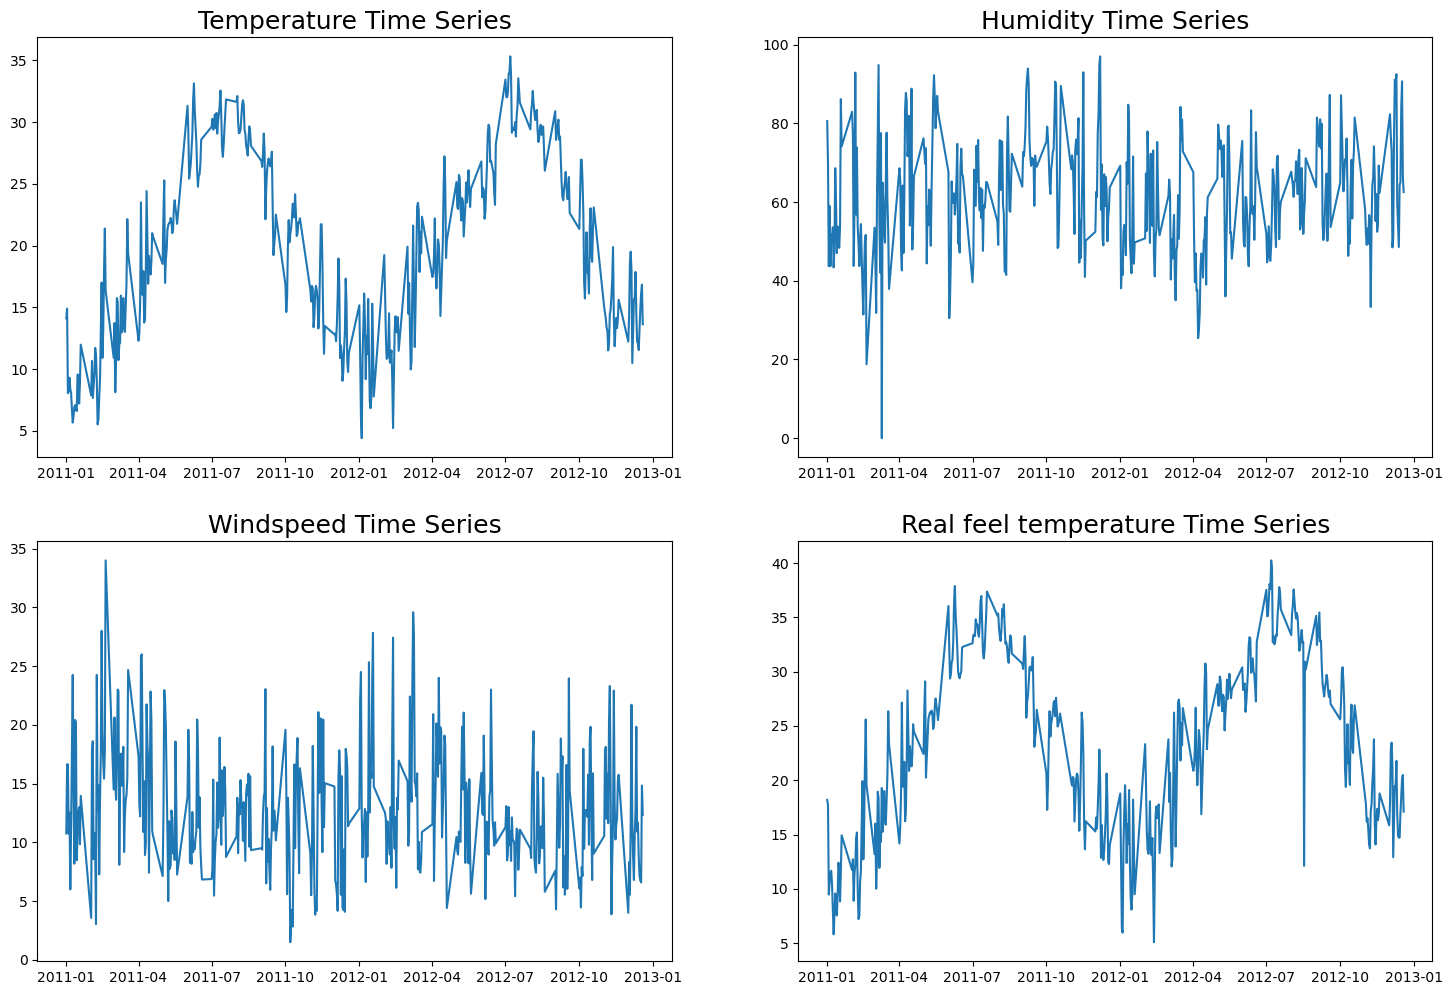

In [189]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (18,12))
ax1.plot(df_daily.index, df_daily['temp'])
ax2.plot(df_daily.index, df_daily['humidity'])
ax3.plot(df_daily.index, df_daily['windspeed'])
ax4.plot(df_daily.index, df_daily['atemp'])
ax1.set_title('Temperature Time Series', fontsize = 18)
ax2.set_title('Humidity Time Series', fontsize = 18)
ax3.set_title('Windspeed Time Series', fontsize = 18)
ax4.set_title('Real feel temperature Time Series', fontsize = 18)

Time series for the four weather observations. The temperature appears to peak about at the same values both year   
and also the lowest temperature is about the same. Humidity remained around the same levels during the two years,   
however there are high fluctuations. The windspeed also volatile however only a few times reached 30. 

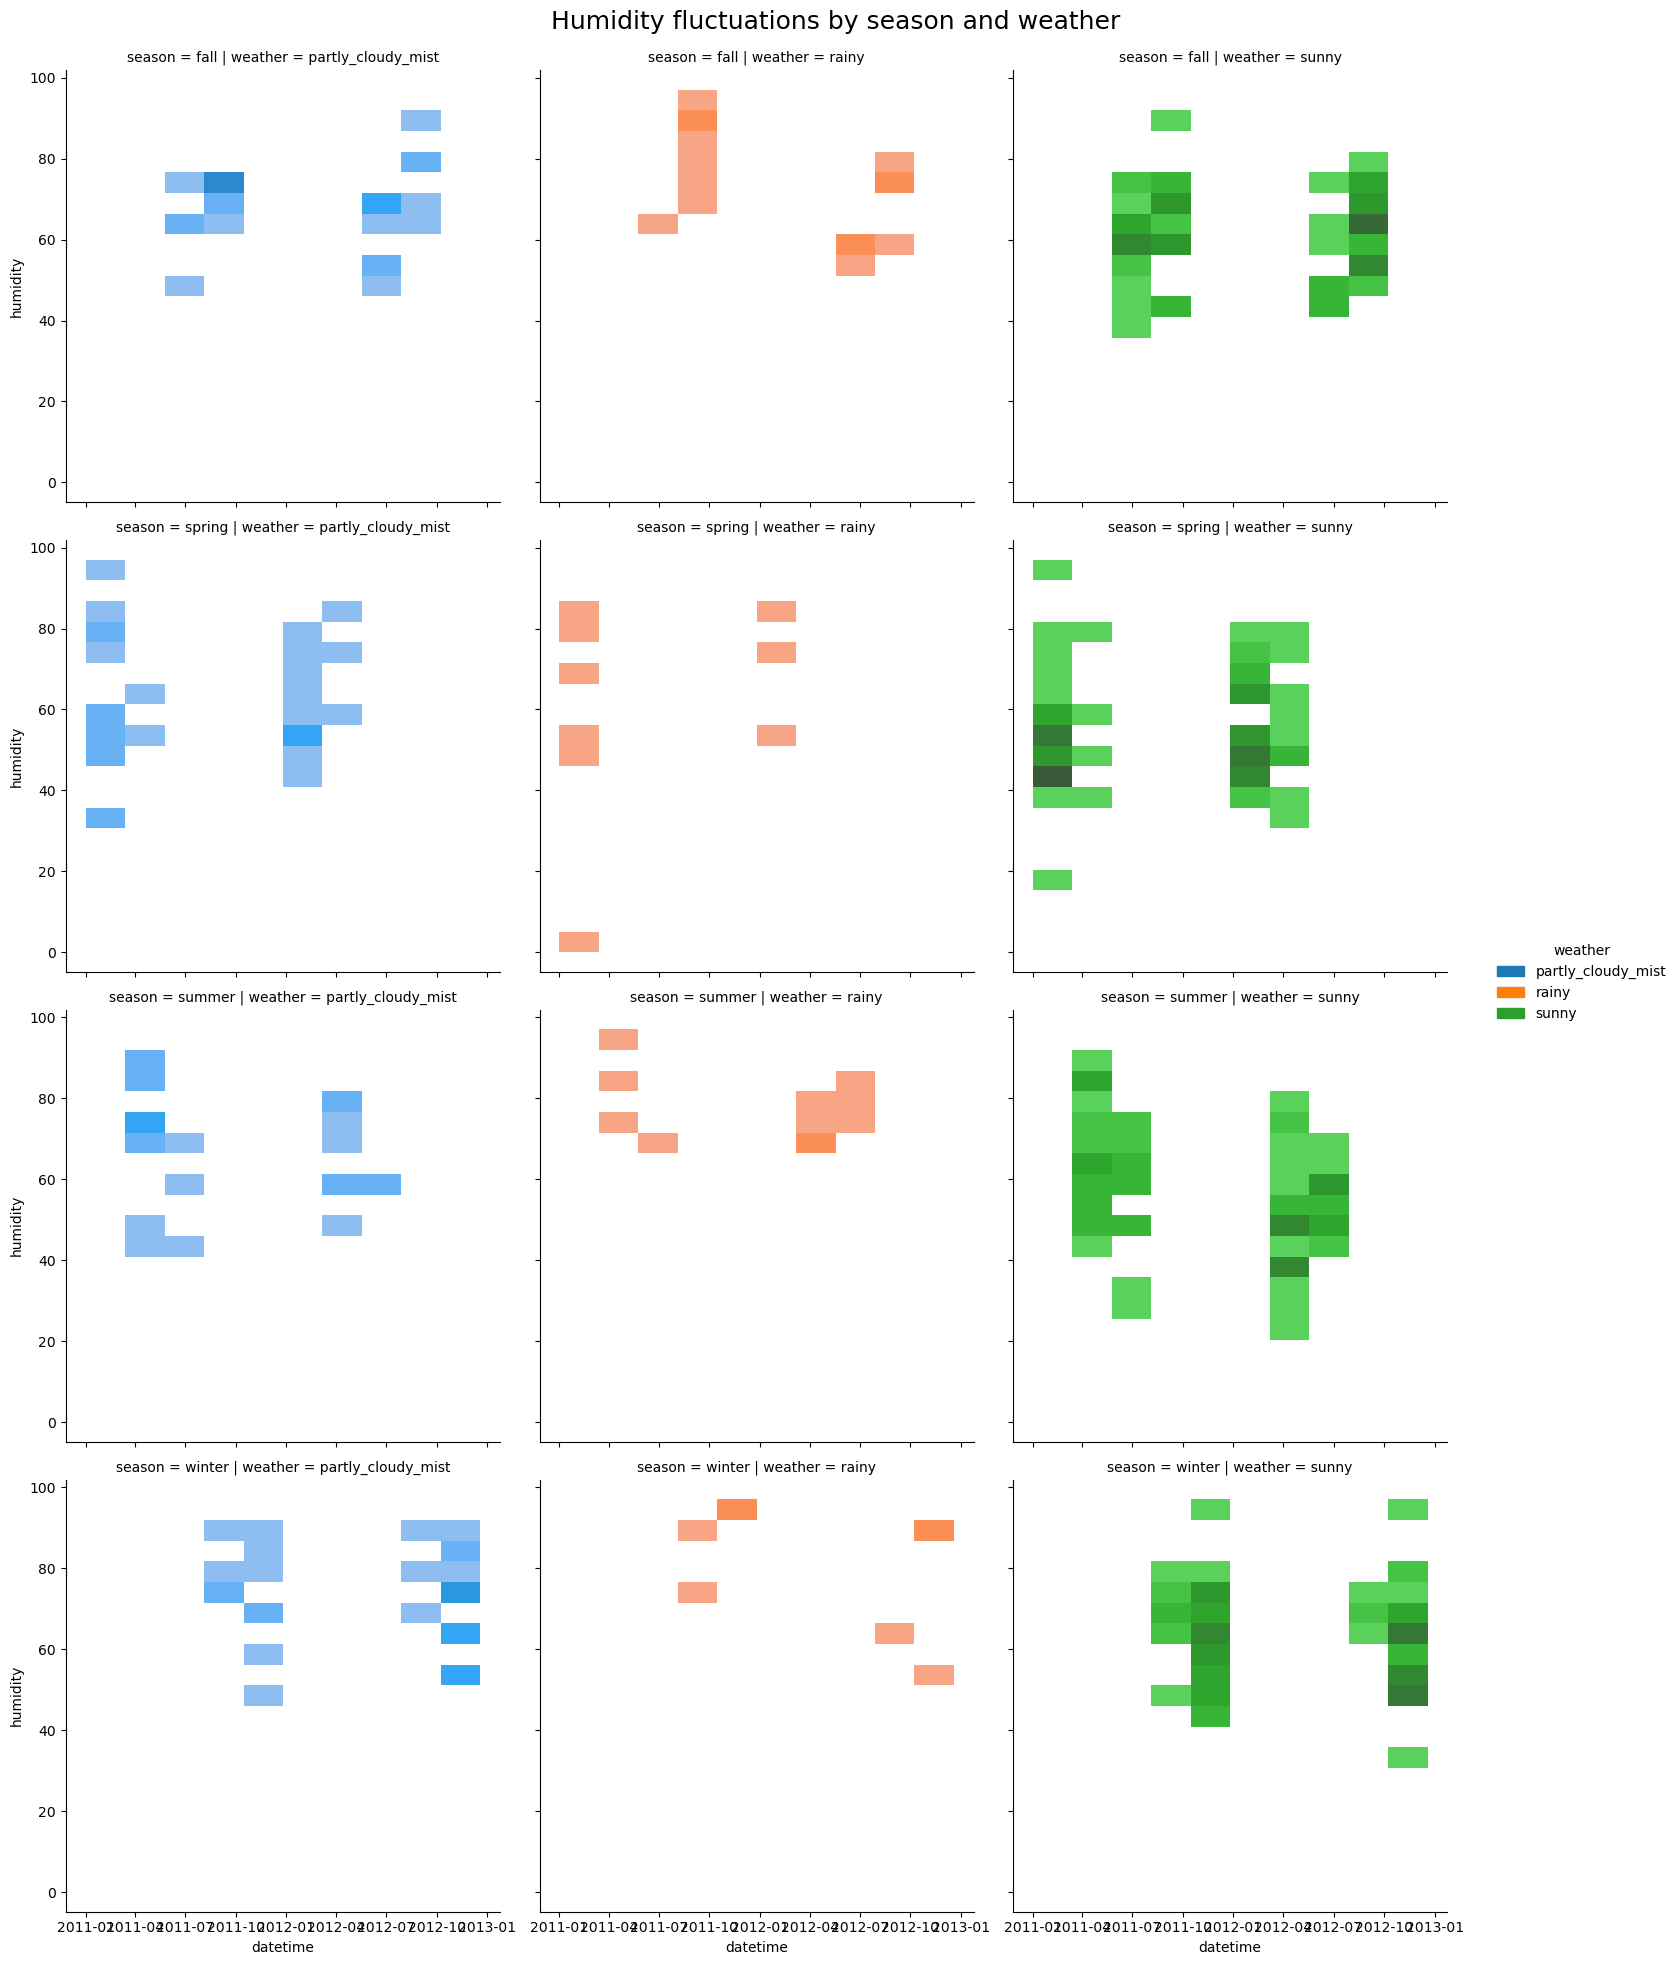

In [190]:
g = sns.displot(data = df_daily, x = df_daily.index, y = 'humidity', col = 'weather', row = 'season', hue = 'weather')
g.fig.subplots_adjust(top = 0.95)
g.fig.suptitle('Humidity fluctuations by season and weather', fontsize = 18)
plt.show()

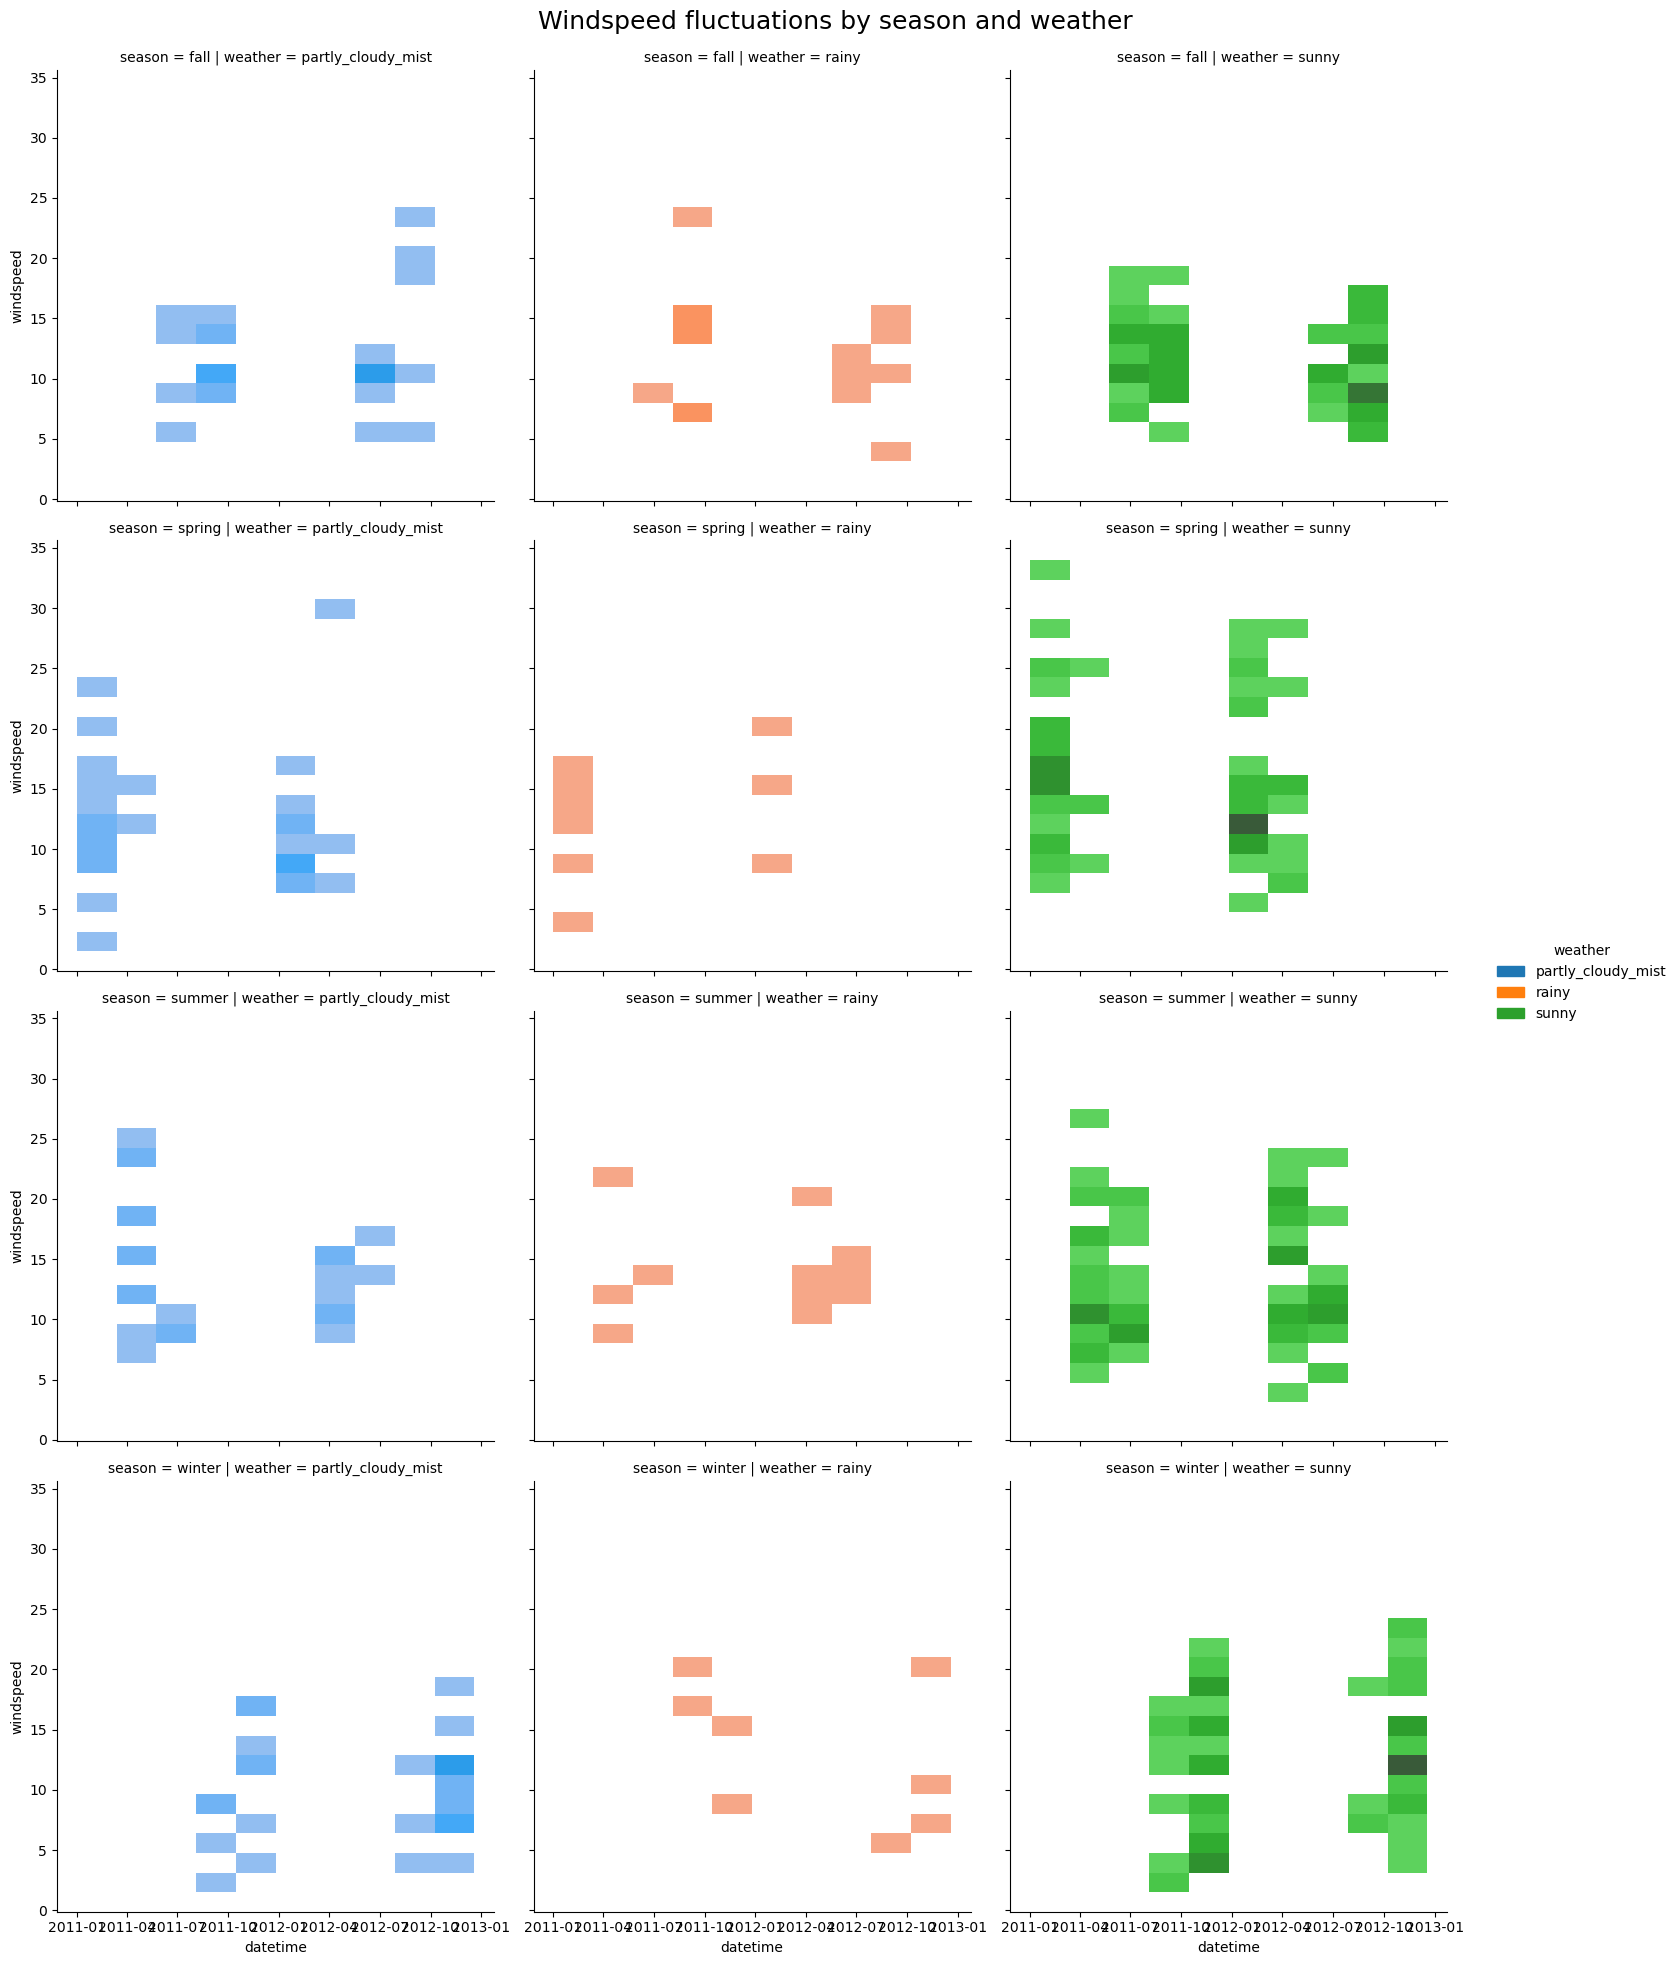

In [191]:
g = sns.displot(data = df_daily, x = df_daily.index, y = 'windspeed', col = 'weather', row = 'season', hue = 'weather')
g.fig.subplots_adjust(top = 0.95)
g.fig.suptitle('Windspeed fluctuations by season and weather', fontsize = 18)
plt.show()

The only insights that we could gain is that both humidity and windspeed fluctuated more in good weather conditions.

## Statistical analysis and model building

For the last part 

In [192]:
df_daily['season'] = df_daily['season'].map({'spring': 1, 'summer': 2, 'fall': 3, 'winter': 4})
df_daily['weather'] = df_daily['weather'].map({'sunny': 1, 'partly_cloudy_mist': 2, 'rainy': 3, 'storm':4})
df_daily['holiday'] = df_daily['holiday'].map({'yes': 1, 'no':0})
df_daily['workingday'] = df_daily['workingday'].map({'yes': 1, 'no':0})

In [193]:
df_daily.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,user_diff,year
datetime,,,,,,,,,,,,,
2011-01-01,1,0,0,2,14.110833,18.181250,80.583333,10.749871,331,654,985,323,2011
2011-01-02,1,0,0,1,14.902609,17.686957,69.608696,16.652122,131,670,801,539,2011
2011-01-03,1,0,1,1,8.050909,9.470227,43.727273,16.636709,120,1229,1349,1109,2011
2011-01-04,1,0,1,1,8.200000,10.606087,59.043478,10.739809,108,1454,1562,1346,2011
2011-01-05,1,0,1,1,9.305217,11.463478,43.695652,12.522300,82,1518,1600,1436,2011


Test whether there is a significant difference between the two years.

In [194]:
# Creating two new dataframes for each year
df_2011 = df_daily.loc[df_daily.index.year == 2011]
df_2012 = df_daily.loc[df_daily.index.year == 2012]

result = scipy.stats.ttest_rel(df_2011['count'], df_2012['count'])
print('The test statistics is: ',result.statistic)
print('The pvalue is: ',result.pvalue)

The test statistics is:  -28.634043868718482
The pvalue is:  2.662520138299607e-77


The test statistics is negative as the sample mean a - b is less than zero and the small pvalue indicates that we can reject the null hypothesis, the equal of averages.    
This is seen from the visualization that the number of users from year one increased significantly therefore we can conclude that year 2011 is different from 2012.

#### Feature importances

In [195]:
X = df_daily.drop(columns = ['casual', 'registered', 'count', 'user_diff', 'year'])
y = df_daily['count']
fs= SelectKBest(score_func=f_regression, k = 4)
fs_best = fs.fit_transform(X, y)
mask = fs.get_support()

X_new = X[X.columns[mask]]
X_new.head()

,season,temp,atemp,windspeed
datetime,,,,
2011-01-01,1,14.110833,18.181250,10.749871
2011-01-02,1,14.902609,17.686957,16.652122
2011-01-03,1,8.050909,9.470227,16.636709
2011-01-04,1,8.200000,10.606087,10.739809
2011-01-05,1,9.305217,11.463478,12.522300


In [196]:
fs= SelectKBest(score_func=mutual_info_regression, k = 4)
fs_best = fs.fit_transform(X, y)
mask = fs.get_support()

print(X[X.columns[mask]].columns)

Index(['season', 'temp', 'atemp', 'humidity'], dtype='object')


The four best features that has an effect on demand are seems to be the season, temperature, feel like temperature and the humidity.   

#### Model for regression and feature importance

1293.4247903162416
feature: season, importance: 0.3947416119403654
feature: holiday, importance: 5.857756189471948e-05
feature: workingday, importance: 0.0007812177580134137
feature: weather, importance: 0.028361176815956922
feature: temp, importance: 0.25470489758740633
feature: atemp, importance: 0.25011104163477704
feature: humidity, importance: 0.06264696224932513
feature: windspeed, importance: 0.008594514452261002


Text(0, 0.5, 'Feature')

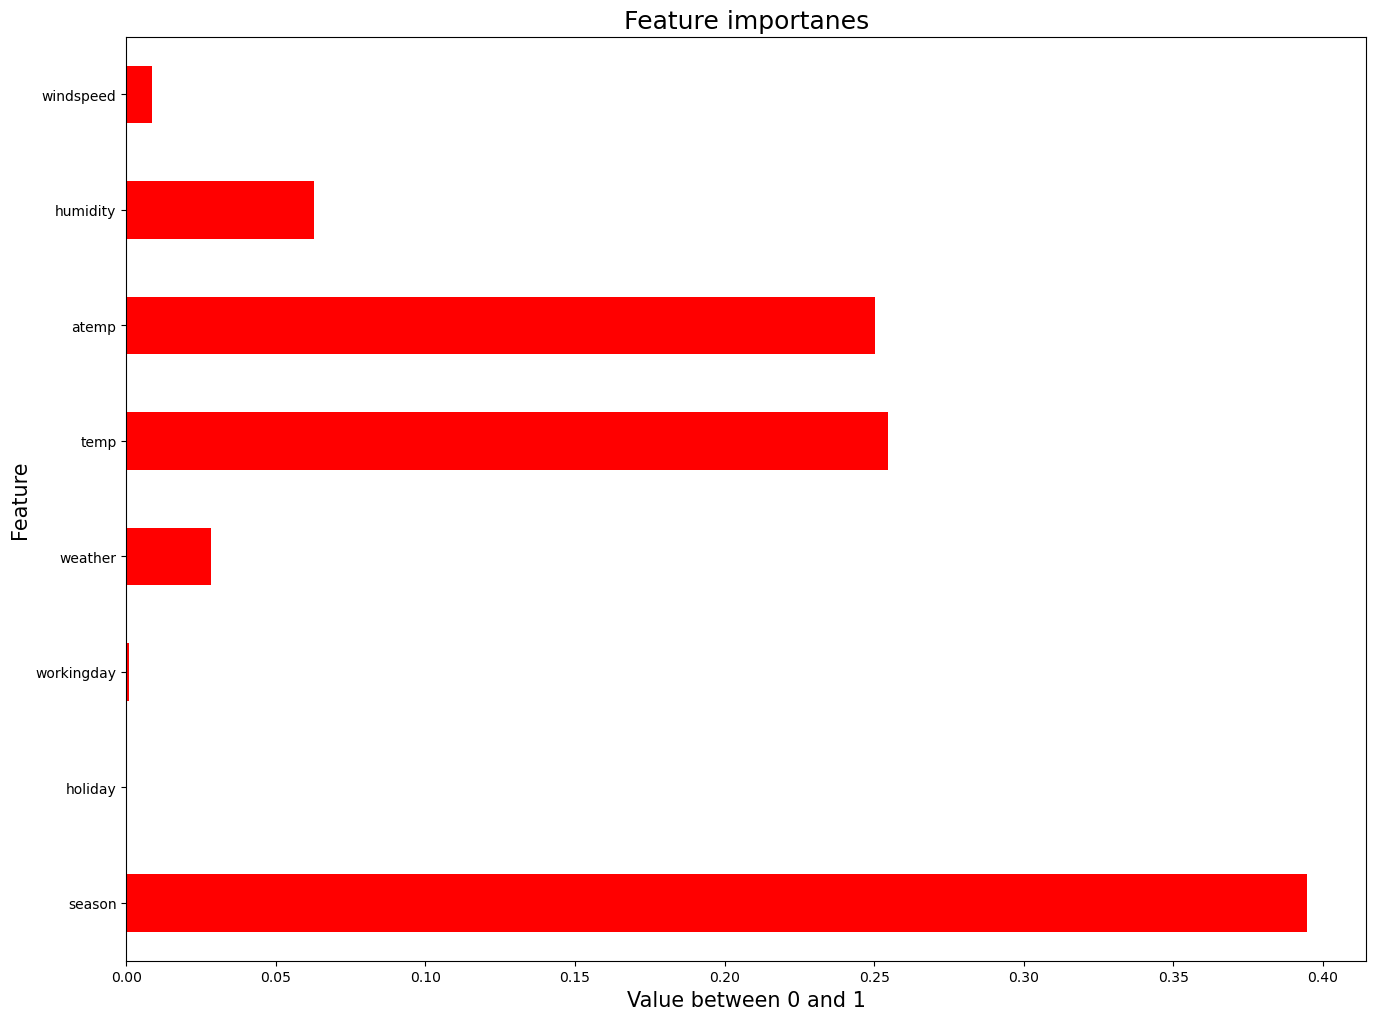

In [197]:
np.random.seed(1234)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

model = ExtraTreesRegressor(n_estimators=500,
                            max_depth=3,
                            random_state = 1234)
model.fit(X_train, y_train)
y_pred = model.predict(X_test).reshape(-1,1)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse)

for feature, importance in zip(X.columns, model.feature_importances_):
    print('feature: {0}, importance: {1}'.format(feature, importance))

(pd.Series(model.feature_importances_, index = model.feature_names_in_).plot(kind = 'barh', color = 'red'))
plt.title('Feature importanes', fontsize = 18)
plt.xlabel('Value between 0 and 1', fontsize = 15)
plt.ylabel('Feature', fontsize = 15)

#### Stepwise ARIMA

In [198]:
size = int(len(df_daily['count']) * 0.8)
train, test = df_daily['count'][0:size], df_daily['count'][size:len(df_daily['count'])]

The p-value for the ADF test is  0.6294115984580124
Estimated differencing term: 1


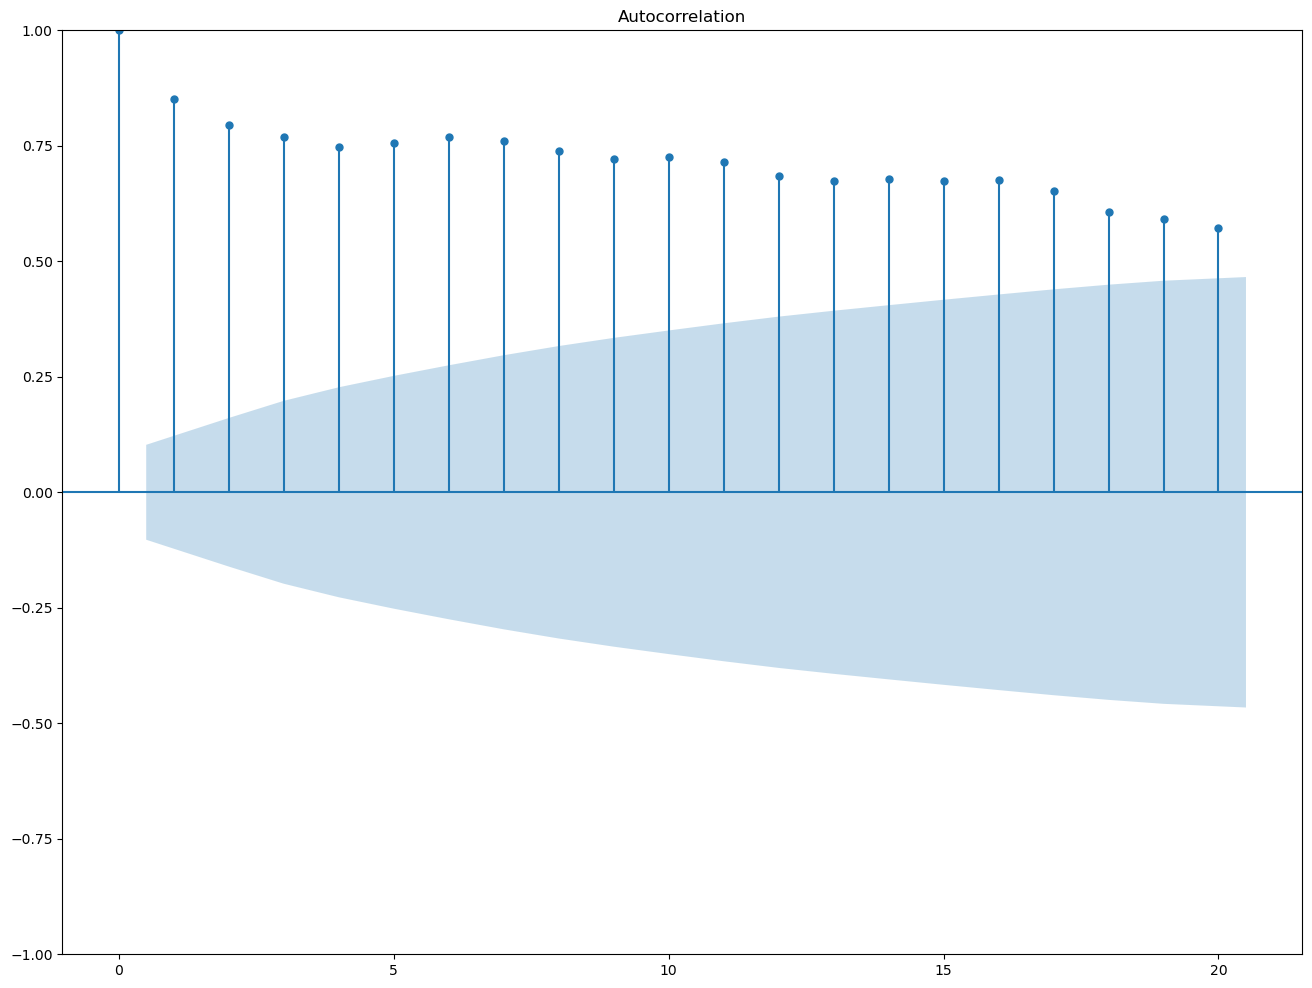

In [199]:
result = adfuller(train)
print("The p-value for the ADF test is ", result[1])

kpss_diffs = ndiffs(train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)
print(f"Estimated differencing term: {n_diffs}")

# Plot the ACF
plot_acf(train, lags=20)
plt.show()

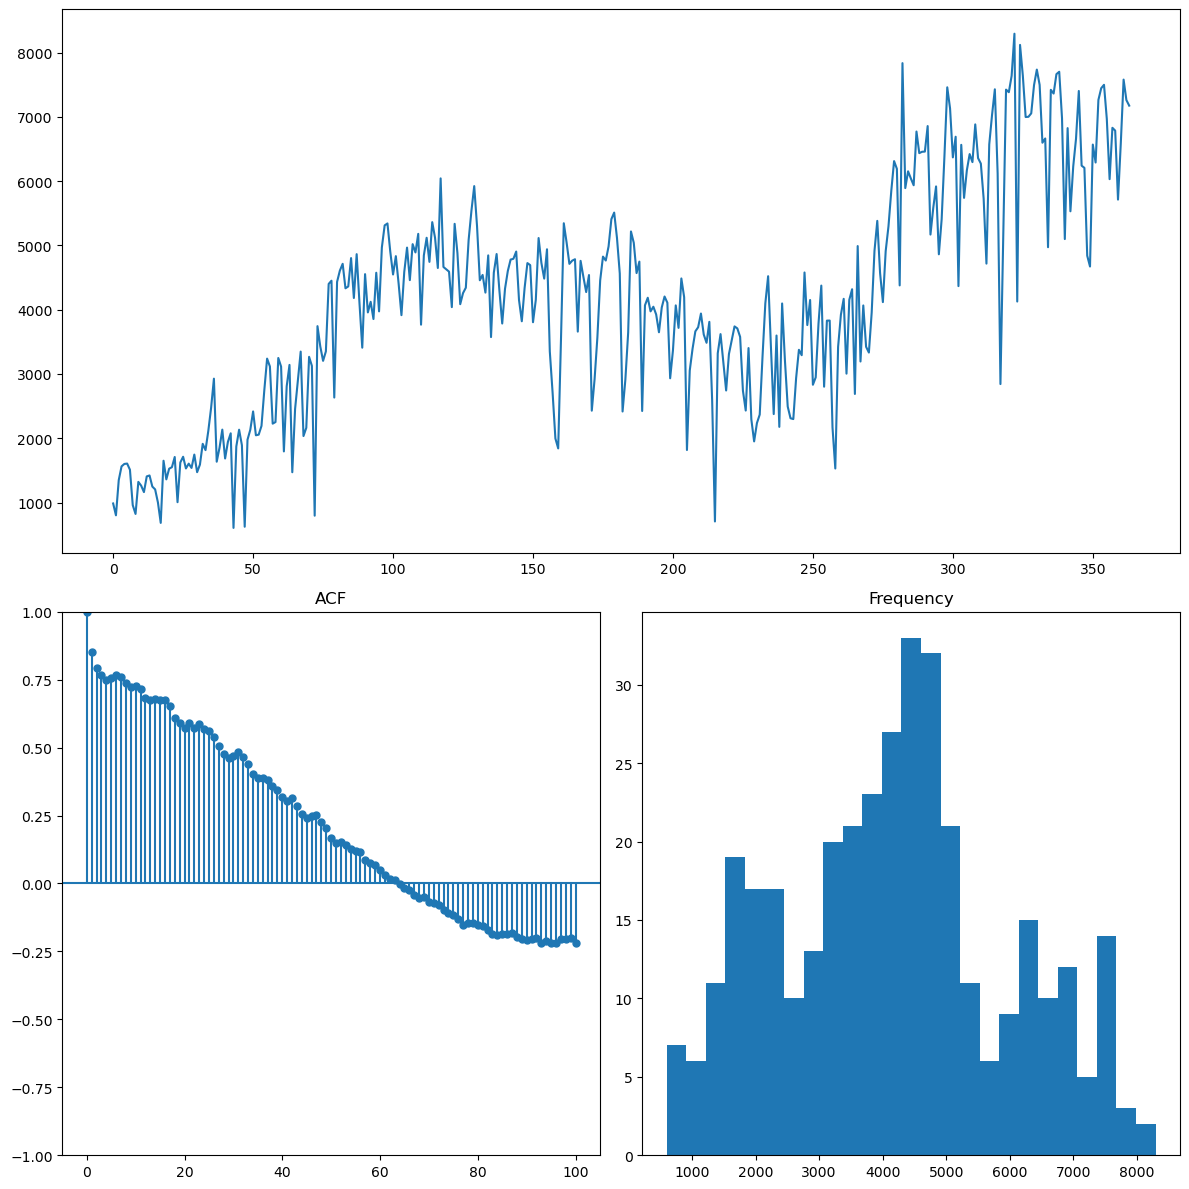

In [200]:
tsdisplay(train, lag_max=100, figsize = (12,12))

Data seems roughly normally distributed, there is no need to do transformation.   
Let's run auto_arima that automatically discovers the optimal order for the ARIMA model we later try to fit.

In [201]:
kpss_diffs = ndiffs(train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)
print(f"Estimated differencing term: {n_diffs}")

ocsb_diffs = nsdiffs(train, m=12, test='ocsb', max_D=4)
ch_diffs = nsdiffs(train, m=12, test='ch', max_D=4)
ns_diffs = max(ocsb_diffs, ch_diffs)
print(f"Estimated seasonal differencing term: {ns_diffs}")

# Automatic parameter selection
auto_model = auto_arima(train, start_p = 1, start_q = 1,
                          max_p = 4, max_q = 3, m = 12,
                          start_P = 1, seasonal = True,
                          d = n_diffs, D = 1, trace = True,
                          error_action ='ignore',
                          suppress_warnings = True, 
                          stepwise = True)
auto_model.summary()

Estimated differencing term: 1
Estimated seasonal differencing term: 0
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=1.44 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=6075.864, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5924.430, Time=0.64 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.56 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=6038.777, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5876.754, Time=1.19 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.93 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.09 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5922.281, Time=0.96 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=5860.838, Time=1.54 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=5901.802, Time=0.96 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=2.31 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.14 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=58

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  364
Model:             SARIMAX(4, 1, 1)x(2, 1, [], 12)   Log Likelihood               -2894.502
Date:                             Thu, 04 Jan 2024   AIC                           5805.003
Time:                                     21:05:49   BIC                           5835.890
Sample:                                          0   HQIC                          5817.296
                                             - 364                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1670      0.066      2.529      0.011       0.038       0.296
ar.L2         -0.0514      0.064     -0.804      0.422      -0.177       0.074
ar.L3         -0.0937      0.067     -1.398      0.162      -0.225       0.038
ar.L4         -0.1082      0.062     -1.752      0.080      -0.229       0.013
ma.L1         -0.7996      0.054    -14.943      0.000      -0.905      -0.695
ar.S.L12      -0.6933      0.050    -13.844      0.000      -0.791      -0.595
ar.S.L24      -0.3521      0.059     -5.953      0.000      -0.468      -0.236
sigma2      8.427e+05   4.93e+04     17.111      0.000    7.46e+05    9.39e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                53.39
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               2.50   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The discovered best order seems to be ARIMA(4,1,1)(2,1,0)[12].

In [202]:
model = auto_model

def forecastDemand():
    fc, conf_int = model.predict(n_periods=10, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in test:
    fc, conf = forecastDemand()
    forecasts.append(int(round(fc,0)))
    confidence_intervals.append(conf)
    model.update(new_ob)

print(f'Symmetric Mean Absolute Percentage Error (SMAPE): {smape(test, forecasts)}')

Symmetric Mean Absolute Percentage Error (SMAPE): 13.911252360749165


The SMAPE is calculated as the average of the absolute percentage errors between the actual values y and the predicted values y_hat,    
where each error is weighted by the sum of the absolute values of the actual and predicted values.    
The resulting score ranges between 0 and 1, where a score of 0 indicates a perfect match between the actual and predicted values, and a score of 1 indicates no match at all.    
A smaller value of SMAPE is better, and it is often multiplied by 100% to obtain the percentage error.  

From our prediction we can see that it's about a 14% error rate.

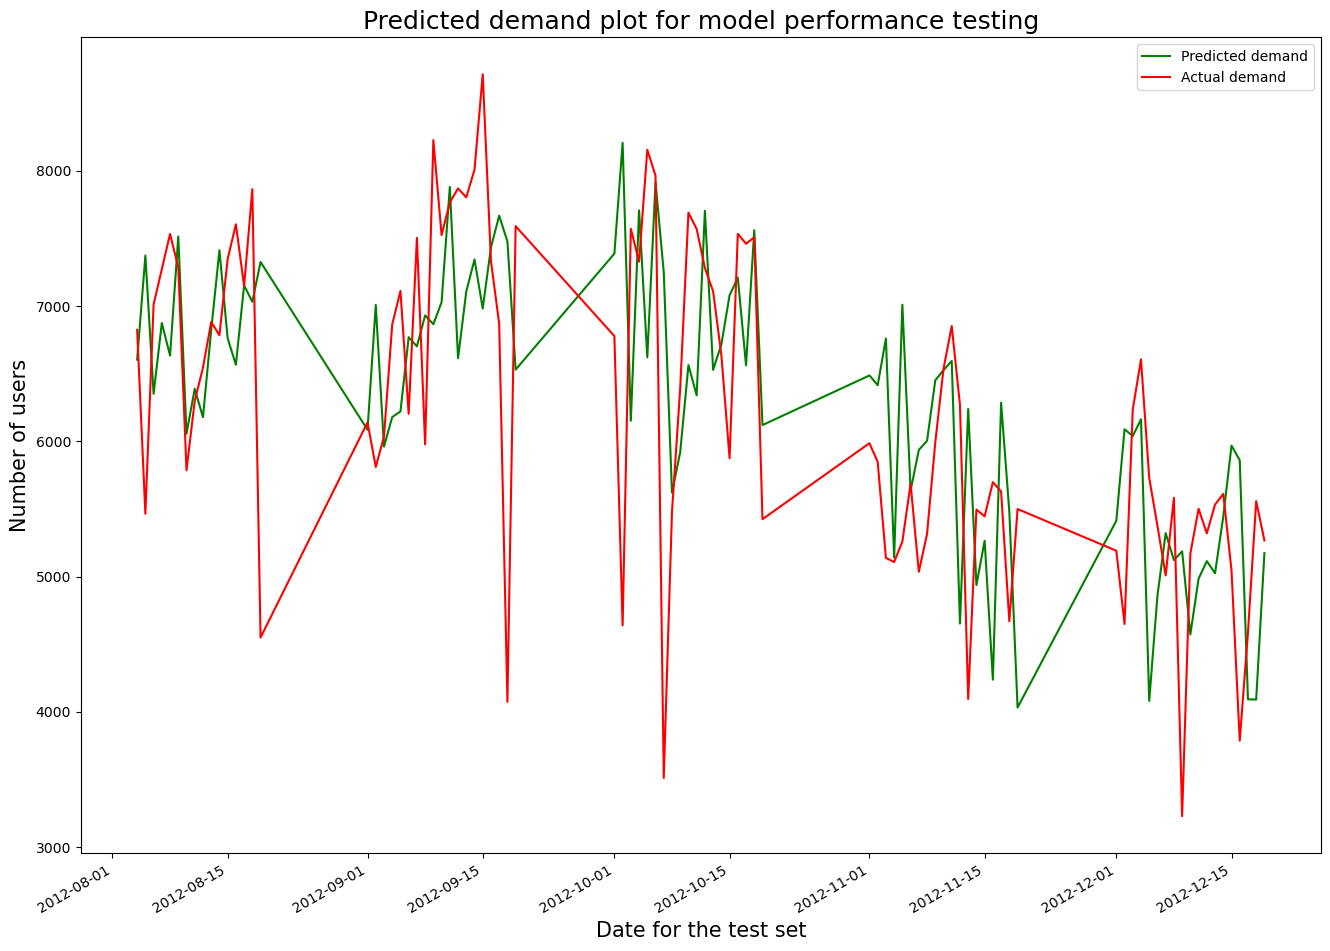

In [203]:
forecasts = pd.Series(forecasts, index = test.index)

forecasts.plot(x = forecasts.index, y = forecasts, color = 'green', label = 'Predicted demand')
test.plot(x = test.index, y = test, color = 'red', label = 'Actual demand')
plt.title('Predicted demand plot for model performance testing', fontsize = 18)
plt.xlabel('Date for the test set', fontsize = 15)
plt.ylabel('Number of users', fontsize = 15)
plt.legend()
plt.show()

#### ARIMA model fitting and forecasting

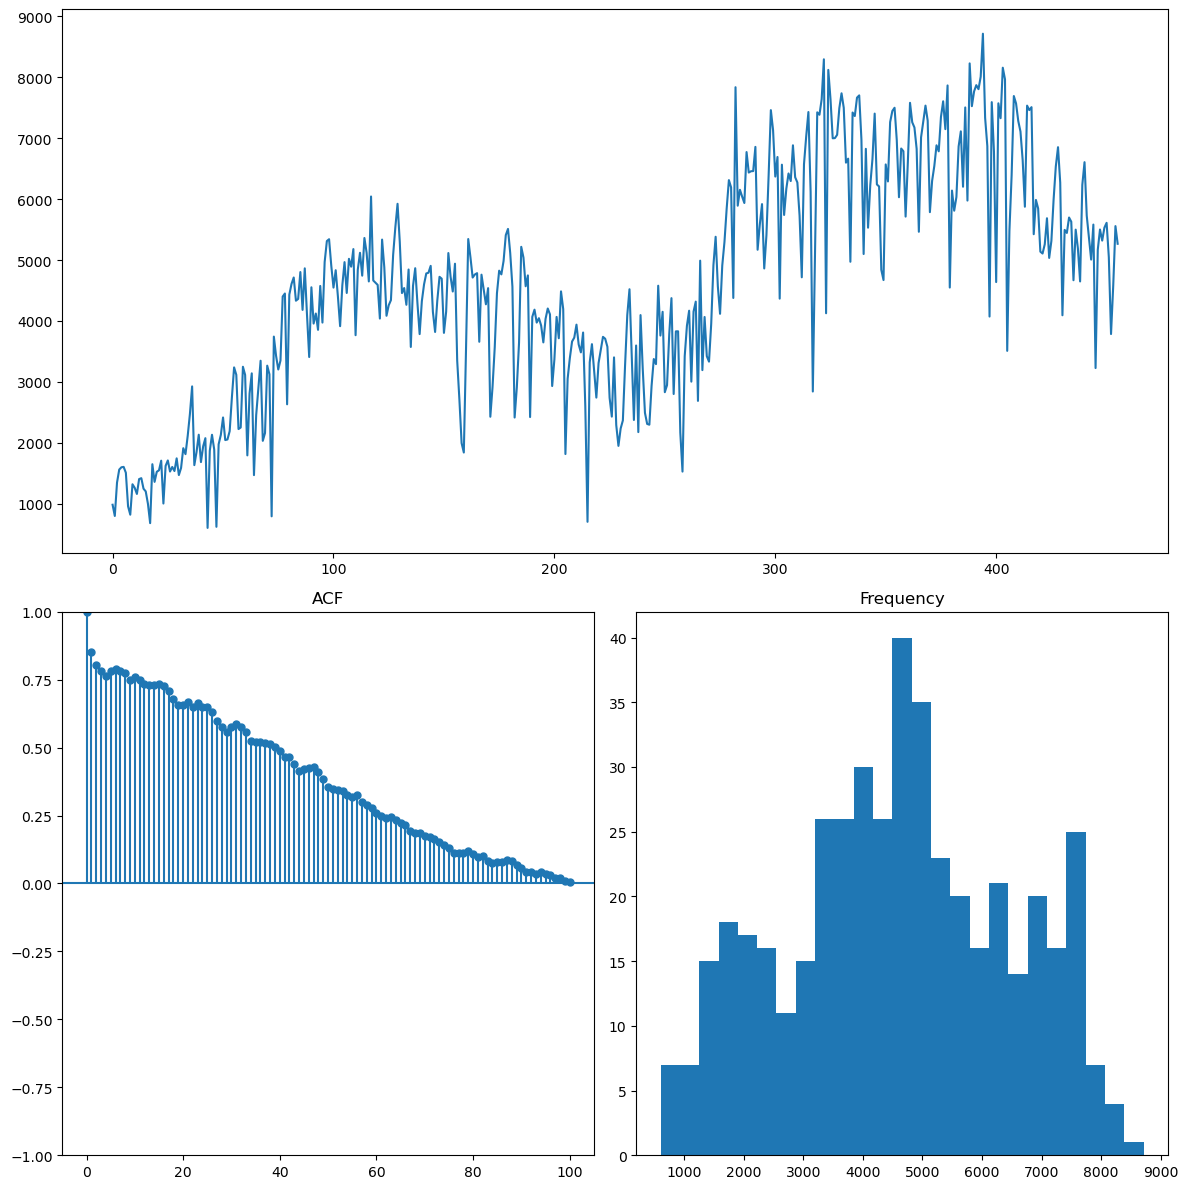

In [204]:
tsdisplay(df_daily['count'], lag_max=100, figsize = (12,12))

Based on the best values found previously tryin to fit the model to the whole dataset and make some forecasting.

                                    SARIMAX Results                                     
Dep. Variable:                            count   No. Observations:                  456
Model:             ARIMA(4, 1, 1)x(2, 0, 1, 12)   Log Likelihood               -3706.963
Date:                          Thu, 04 Jan 2024   AIC                           7431.926
Time:                                  21:07:11   BIC                           7469.009
Sample:                                       0   HQIC                          7446.535
                                          - 456                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1488      0.058      2.562      0.010       0.035       0.263
ar.L2         -0.0725      0.050     -1.457      0.

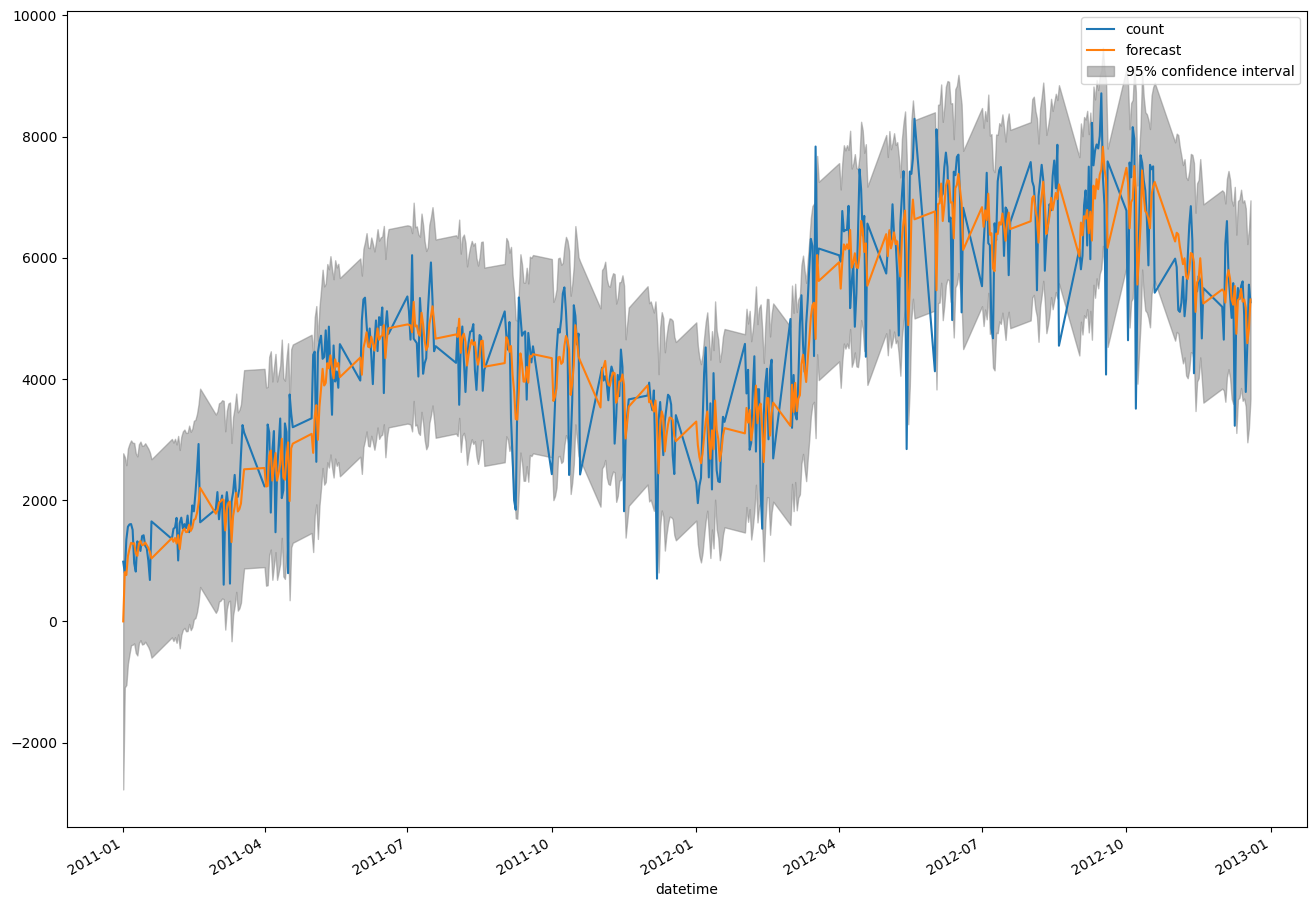

Symmetric Mean Absolute Percentage Error (SMAPE): 16.089271196028573


In [205]:
# ARMA model
mod = ARIMA(df_daily['count'], order=(4,1,1), seasonal_order = (2,0,1,12))
res = mod.fit()
print(res.summary())

# Forecasted values to the end of the year
forecasted = round(res.forecast(steps = 12),0)

fig, ax = plt.subplots()
df_daily['count'].plot(ax=ax)
plot_predict(res, start='2011-01-01', end='2012-12-19', ax=ax)
plt.show()

predicted = res.predict()
print(f'Symmetric Mean Absolute Percentage Error (SMAPE): {smape(df_daily["count"], predicted)}')

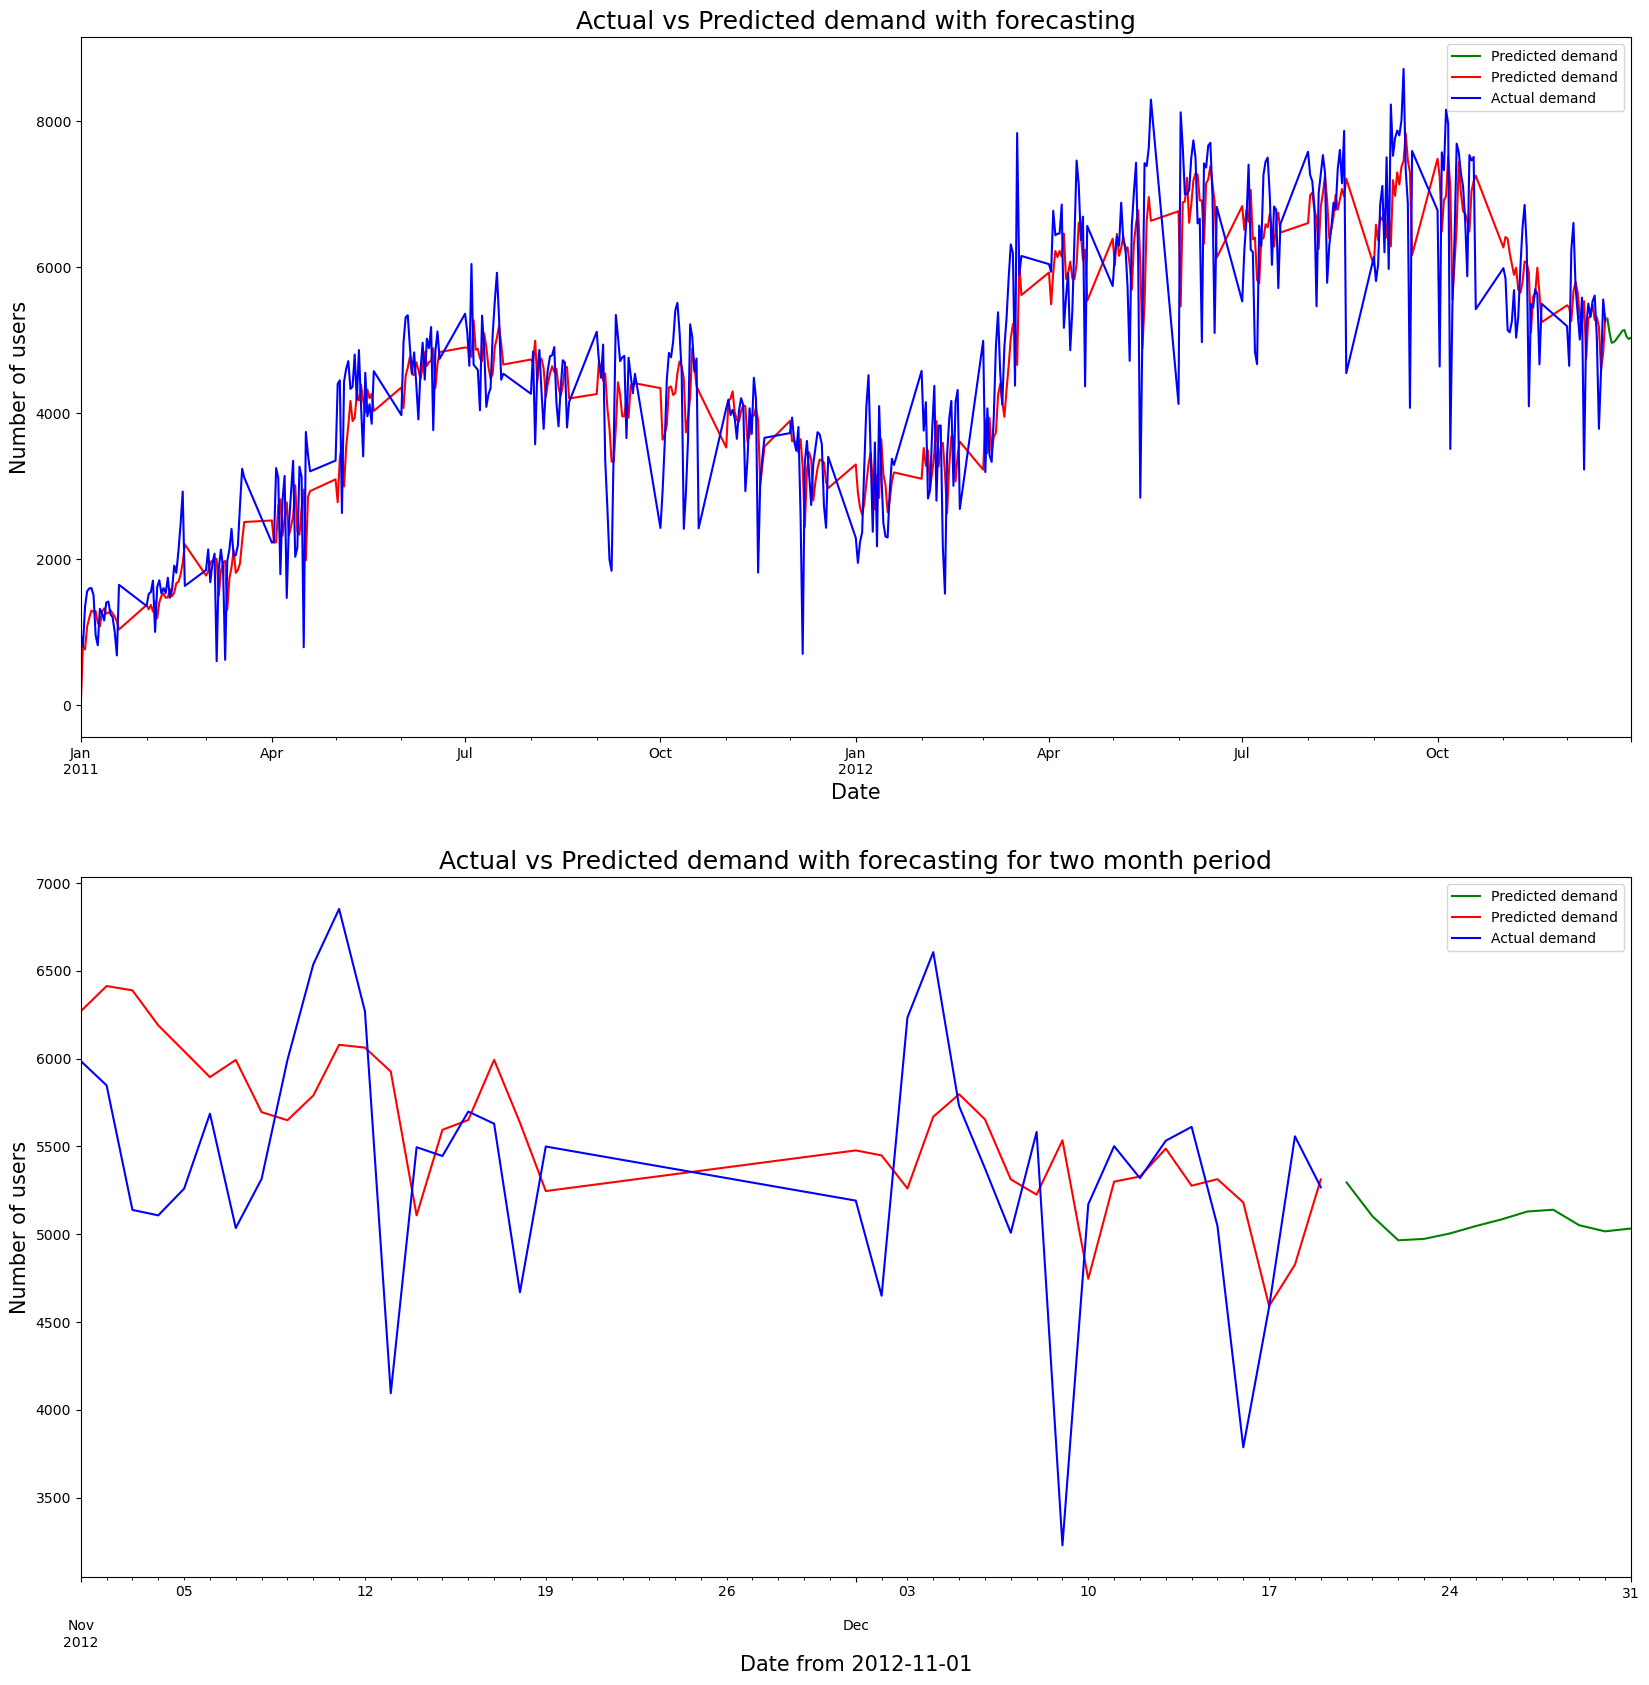

In [206]:
forec = pd.Series(forecasted.values, index = pd.date_range(start = '2012-12-20', end = '2012-12-31'))
predicted = pd.Series(predicted.values, index = df_daily.index)
actual_val = pd.Series(df_daily['count'], index=df_daily.index)

fig, axes = plt.subplots(2, 1, figsize=(20, 20))

forec.plot(x = forec.index, y = forecasted, color = 'green', label = 'Predicted demand', ax = axes[0])
predicted.plot(x = predicted.index, y = predicted, color = 'red', label = 'Predicted demand', ax = axes[0])
actual_val.plot(x = actual_val.index, y = actual_val, color = 'blue', label = 'Actual demand', ax = axes[0])
axes[0].set_title('Actual vs Predicted demand with forecasting', fontsize = 18)
axes[0].set_xlabel('Date', fontsize = 15)
axes[0].set_ylabel('Number of users', fontsize = 15)
axes[0].legend()


predicted_slice = predicted['2012-11-01':]
actual_slice = actual_val['2012-11-01':]
forec.plot(x = forec.index, y = forecasted, color = 'green', label = 'Predicted demand', ax = axes[1])
predicted_slice.plot(x = predicted_slice.index, y = predicted_slice, color = 'red', label = 'Predicted demand', ax = axes[1])
actual_slice.plot(x = actual_slice.index, y = actual_slice, color = 'blue', label = 'Actual demand', ax = axes[1])
axes[1].set_title('Actual vs Predicted demand with forecasting for two month period', fontsize = 18)
axes[1].set_xlabel('Date from 2012-11-01', fontsize = 15)
axes[1].set_ylabel('Number of users', fontsize = 15)
axes[1].legend()
plt.show()


The forecasted demand looks like follows a downward pattern, just like in the previous year.    
These numbers need to be considered with some error just like before.